## Increasing mean read depth is expected to increase the signal-to-noise ratio

Read depth $N$ can be interpreted as a noisy signal: the signal is assumed to be a number $N_s$ that is dependent upon the local DNA sequence and the noise comes from Poisson fluctuations about that signal: 

\begin{equation} 
P(N=k) = \frac{N_s^{k} e^{-N_s}}{k!} .
\end{equation} 

The signal-to-noise ratio is therefore 

\begin{equation} 
\frac{\langle N \rangle}{\sigma(N)} = \frac{N_s}{\sqrt{N_s}} = \sqrt{N_s} = \sqrt{\langle N \rangle}, 
\end{equation} 

which grows as the mean depth increases: 


Text(0,0.5,'signal-to-noise ratio')

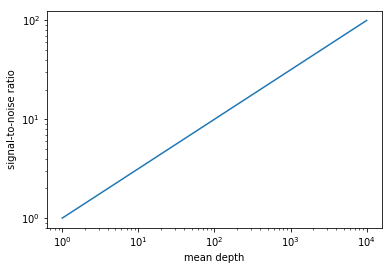

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt 
import numpy as np 

mean_depth = np.arange(1,10000)
SNR = np.sqrt(mean_depth)
plt.loglog(mean_depth, SNR)
plt.xlabel('mean depth')
plt.ylabel('signal-to-noise ratio')

When the signal to noise ratio is small, small variations in the signal will be drowned in the Poisson noise. Conversely, when the signal-to-noise ratio is large, those small variations in signal will become detectable above the noise. 

To illustrate, suppose

\begin{equation} 
N_s = \alpha ( 1 \pm \beta ) ,
\end{equation} 

where $\beta \ll 1$ is the fractional variation in the signal and $\alpha$ is the mean signal. 




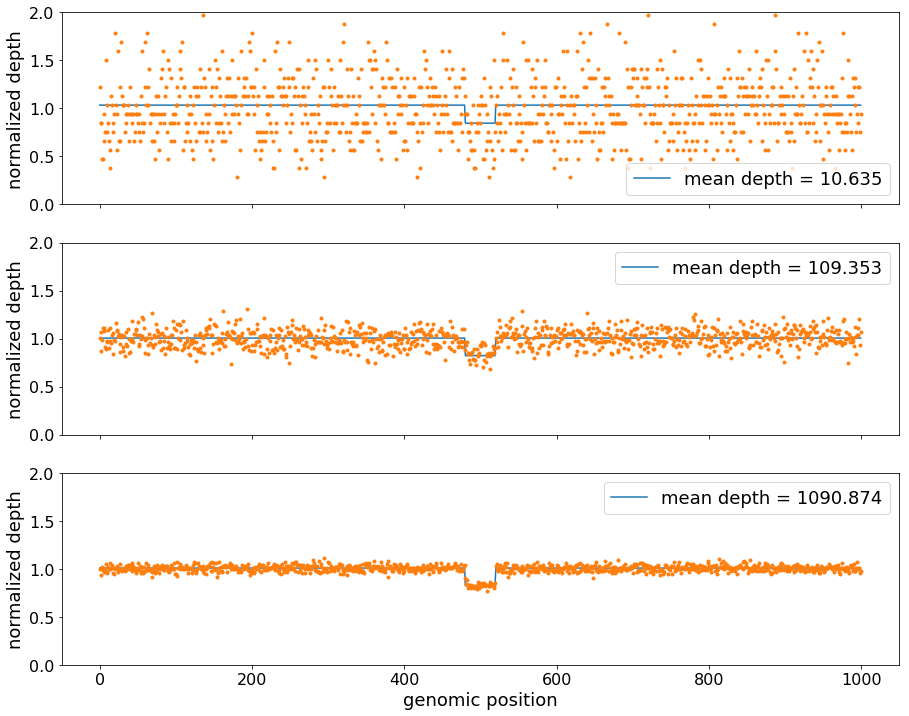

In [2]:
from plot import format_fig, format_axis

def compute_signals(positions, alpha=1, beta=0.1): 
    L1 = np.percentile(positions, 48)
    L2 = np.percentile(positions, 52)
    signals = np.ones_like(positions, dtype=float)*alpha*(1-beta)
    signals[(positions < L1) | (positions > L2)] = alpha*(1+beta)
    return signals

def compute_noisy_signals(signals):
    depths = np.random.poisson(lam = signals[:, np.newaxis], size=(len(signals), 1)) 
    return depths.flatten()

def plot_noisy_signal(axis, alpha, beta): 
    positions = np.arange(1000)
    signals = compute_signals(positions, alpha, beta)
    noisy_signals = compute_noisy_signals(signals)
    mean_depth = np.mean(noisy_signals)
    axis.plot(positions, signals/mean_depth, '-', label='mean depth = {}'.format(mean_depth))
    axis.plot(positions, noisy_signals/mean_depth, '.')
    axis.set_ylim([0, 2])
    axis.set_ylabel('normalized depth')
    axis.legend()
    format_axis(axis)
    
def plot_noisy_signals(beta, figure_file_name=None): 
    alphas = [10, 100, 1000]
    figure, axes = plt.subplots(len(alphas), 1, sharex=True, sharey=True)
    format_fig(figure, height=12)
    for axis, alpha in zip(axes, alphas): 
        plot_noisy_signal(axis, alpha, beta)
    axis.set_xlabel('genomic position')
    if figure_file_name:
        plt.savefig(figure_file_name, bbox_inches='tight')

plot_noisy_signals(beta=0.1)

In line with expectations from our signal-to-noise ratio calculation, the true variation in the signal becomes apparent in the Poisson-contaminated signal as  the mean depth increases. 

This does not mean, however, that no signal variation is evident at low mean depth. Although Poisson noise is large in this regime, a change in signal may still be visible if it is larger than the noise, as the following example illustrates: 

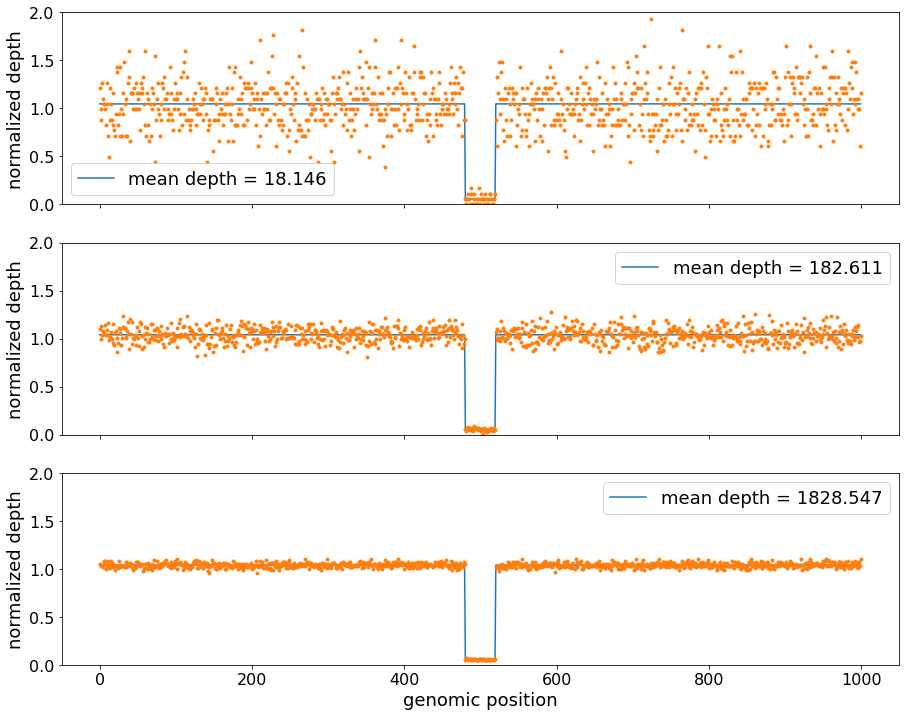

In [3]:
plot_noisy_signals(beta=0.9)

## Systematic biases in real depth data emerge out of the noise when samples are pooled 

Armed with intution about what to expect when the mean-depth is increased, let us now turn to real data to see whether those expectations are borne out. We pooled the read depths across hundreds of samples to simulate the effect of increasing the mean sequencing depth. These samples came from a collection known as CEPH and were identically prepared. For comparison, we also show a single sample, hg002, that was prepared differently (by GIAB). 

Let's examine the effect of pooling read-depth profile across the entire length of chromosome 22 ... 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


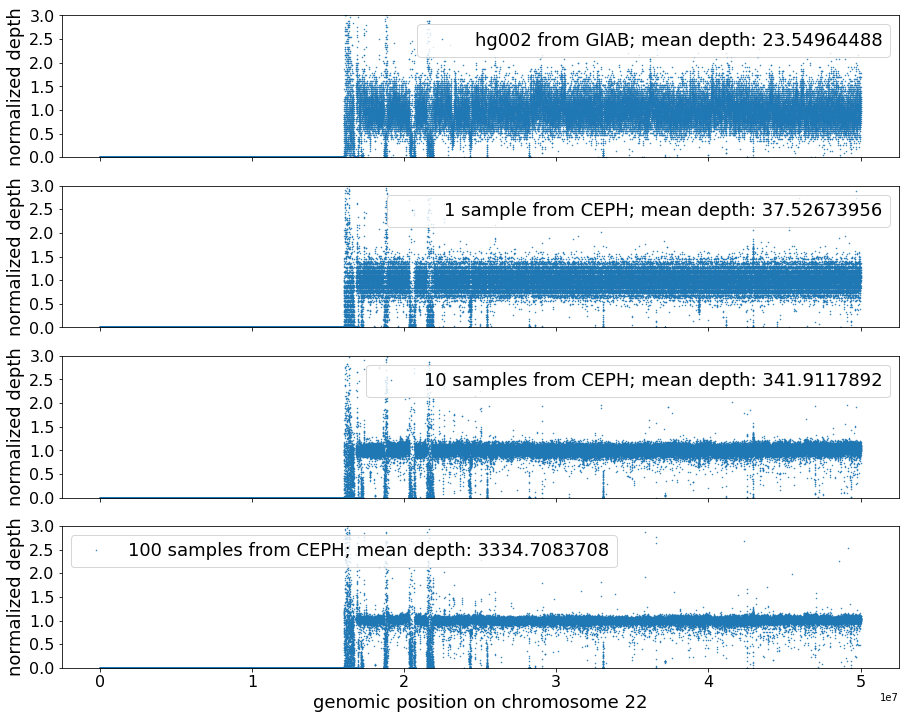

In [4]:
def plot_depth_profile(axis, data, region, normalized_depth_max, size, grid):
    import re
    chromosome, start, end = re.split(':|-', region)
    assert(int(chromosome) == 22)

    from load_preprocess_data import read_depths
    from utility import named_tuple
    depths = read_depths(named_tuple({'chromosome_number': chromosome, 'depth_file_name': data['file_name']}))
    from load_preprocess_data import compute_observed_depth_mean
    mean_depth = compute_observed_depth_mean(depths, chromosome)
    
    sampled_positions = np.random.choice(np.arange(int(start), int(end), dtype=int), size=size, replace=False)
    sampled_depths = depths[sampled_positions]
    axis.plot(sampled_positions, sampled_depths/mean_depth, '.', ms=1, label=data['title']+'; mean depth: '+str(mean_depth))
    axis.set_ylabel('normalized depth')
    axis.set_ylim([0, normalized_depth_max])
    if grid:
        axis.grid(which='major', axis='y')
    plt.legend(loc=1)
    format_axis(axis)
    axis.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    return 'genomic position on chromosome ' + chromosome

def plot_depth_profiles(region, normalized_depth_max=3, size=100000, grid=None, figure_file_name=None): 
    data_sets = [{'file_name': '../data/depths/hg002/hg002.chr22.multicov.int16.bin', 'title': 'hg002 from GIAB'},
                 {'file_name': '../data/depths/1.multicov.int32.bin', 'title': '1 sample from CEPH'},
                 {'file_name': '../data/depths/10.multicov.int32.bin', 'title': '10 samples from CEPH'},
                 {'file_name': '../data/depths/100.multicov.int32.bin', 'title': '100 samples from CEPH'}]
    figure, axes = plt.subplots(len(data_sets), 1, sharex=True, sharey=True)
    format_fig(figure, height=12)
    for axis, data_set in zip(axes, data_sets): 
        xlabel = plot_depth_profile(axis, data_set, region=region, normalized_depth_max=normalized_depth_max, size=size, grid=grid)
    axis.set_xlabel(xlabel)
    if figure_file_name:
        plt.savefig(figure_file_name, bbox_inches='tight')


plot_depth_profiles(region='22:0-50000000')

As expected theoretically, the noise in the normalized depth profile decreases as the mean depth (number of samples) increases. 

Zooming in, we notice, interestingly, that there are "events" within which the read depth seems to be approximately exponential (with smaller read depths more frequent than larger read depths). These inter-event distributions are clearly not Poisson noise. I wonder if there is an hypothesis for the origin of these inter-event fluctuations?


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


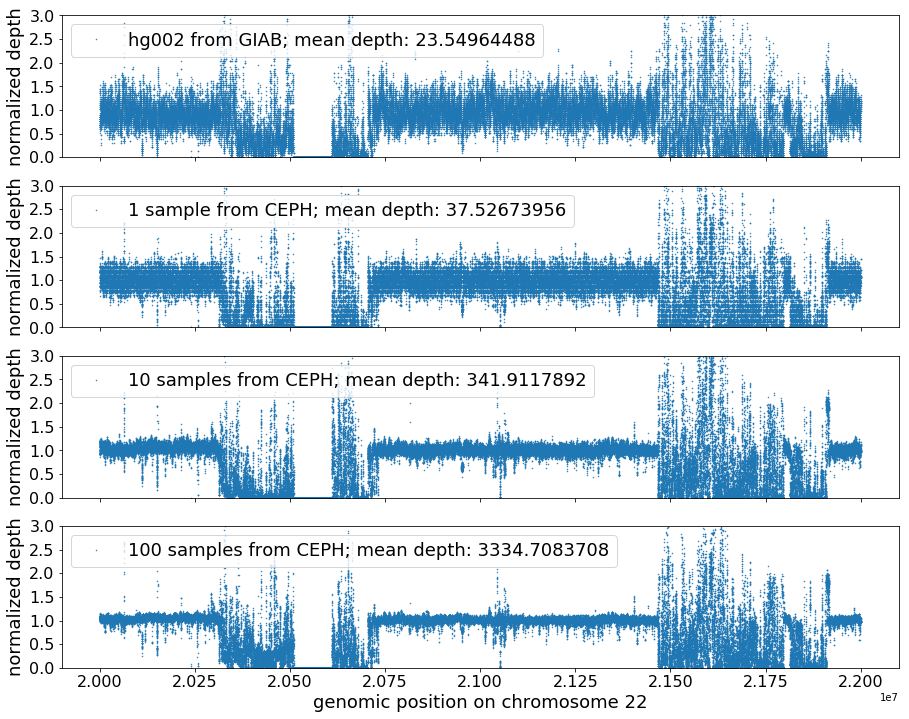

In [5]:
plot_depth_profiles(region='22:20000000-22000000')

Repeating this analysis in another region illustates nicely how pooling samples gives us the power to detect what appears to be variation in signal that would otherwise be invisible. As Poisson noise is dialed down in the CEPH samples by pooling them, real signals emerge, including what appear to be a number of copy-number variants (peaks and troughs that coincide with half-integer values of normalized depth) and smaller variations in coverage, presumably driven by variations in sequence...

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


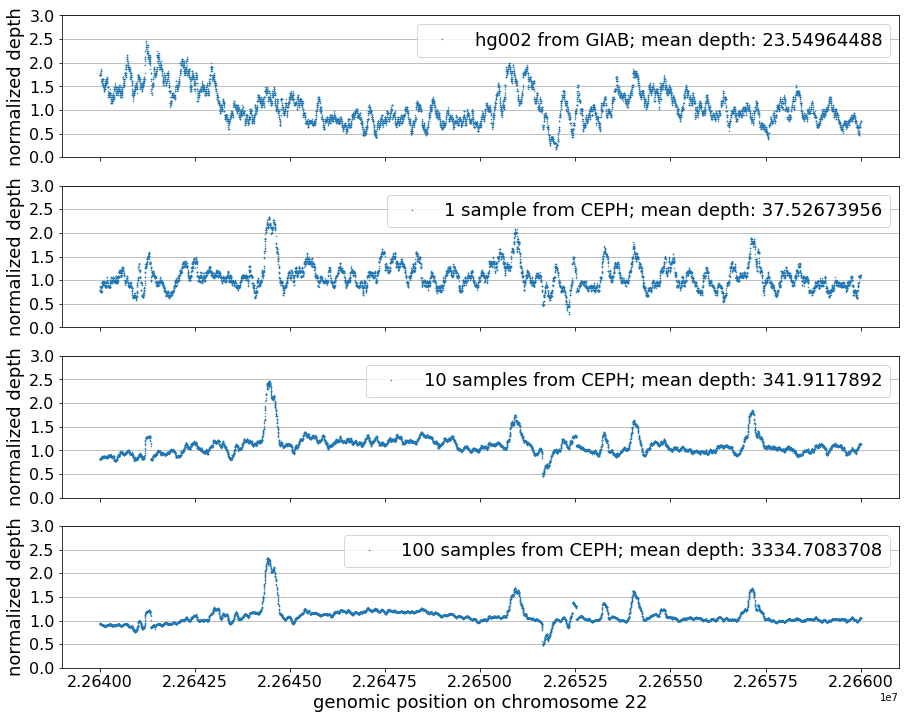

In [6]:
plot_depth_profiles(region='22:22640000-22660000', size=10000, grid=True)

Notice that the trends visible in CEPH, even in a single CEPH sample, are not present in the GIAB sample. Presumably this is because the GIAB sample was prepared differently than any of the CEPH samples. 

## Denoising: Training on pooled samples

Having corrected the rampant "mislabeling" of training examples resulting from Poisson noise, we trained the model again and examined its ability to predict what appear to be systematic variations in read depth that don't result from CNVs ...

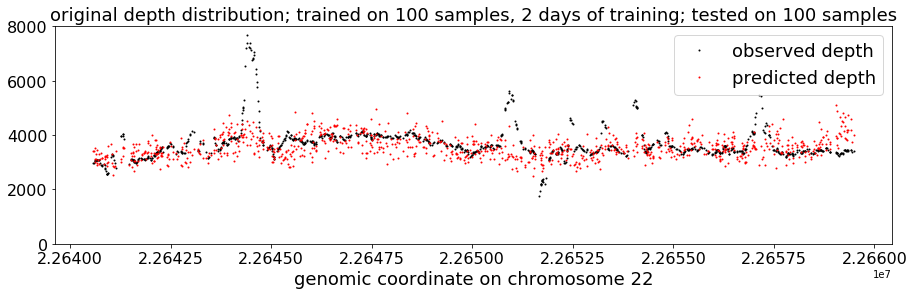

In [7]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'original depth distribution; trained on 100 samples, 2 days of training; tested on 100 samples',
     'test_file_name': 'test001/test.pkl'}
]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=8000)

Notice that the algorithm learns to predict small upticks in read depth (between chromosomal positions 22,645,000 and 22,650,000) but not large ones (e.g. just before 22,645,000). This is presumably because the small fluctuation is sequence-dependent whereas the large fluctuation is not. 




We can explore this further by comparing normalized depth (observed depth divided by mean depth) with corrected depth (observed depth divided by predicted depth): 


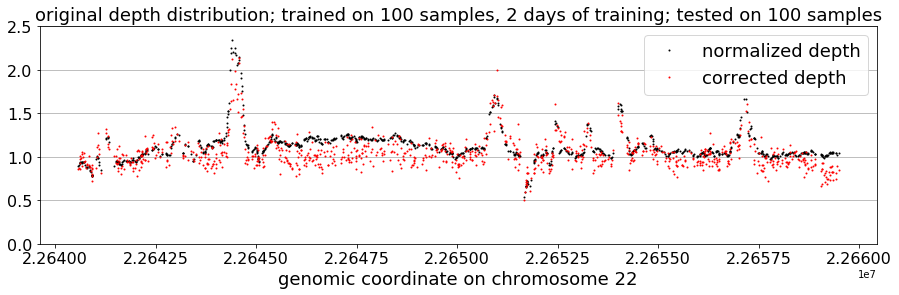

In [8]:
from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22, max_y=2.5)

Notice that the spikes that occur near half-integer values of normalized depth, and are therefore likely to be CNVs,  survive the denoising, while other smaller fluctuations in read depth get shifted toward unit values of normalized read depth. 

## Avoiding overfitting (high variance): Early stopping

The result above was achieved by stopping the training early in order to avoid overfitting the training data....

observed_depth_mean 3284.842
feature_independent_cost 65.99666561647801


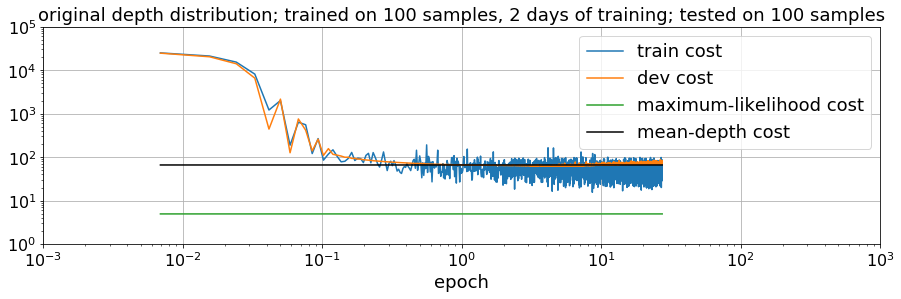

In [9]:
start_epoch = 0.001
end_epoch = 1000
min_cost = 1
max_cost = 100000

from plot import plot_costs_all
plot_costs_all(trained_models, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=max_cost, loglog=True)

## Testing the multi-sample model on the pool of CEPH samples at hg002-CNVnator-call positions 

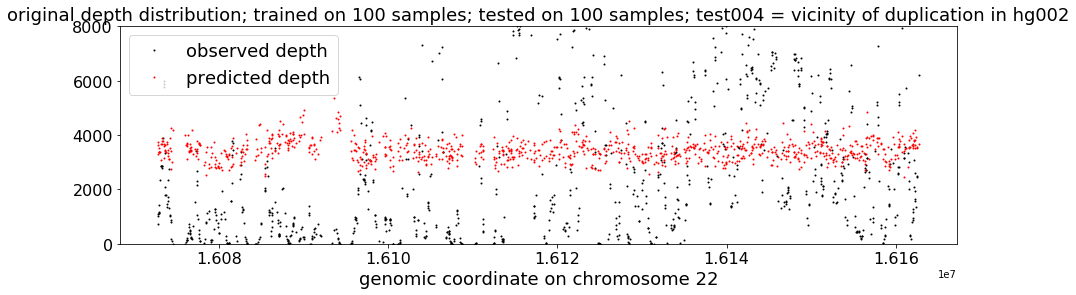

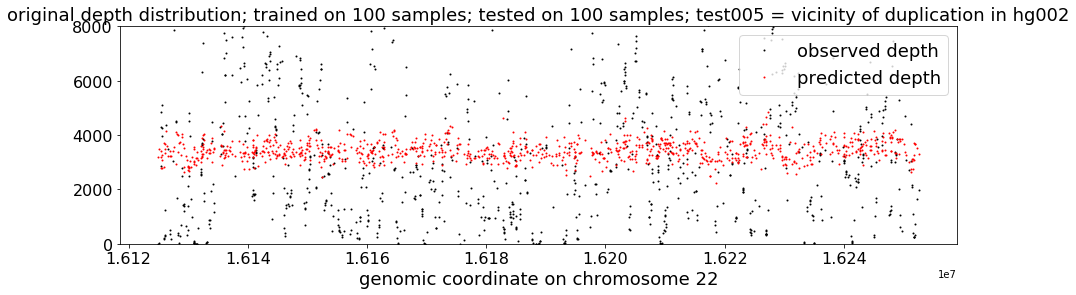

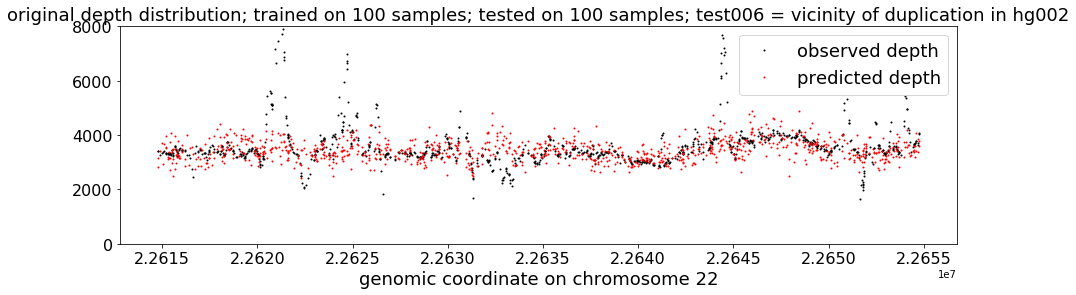

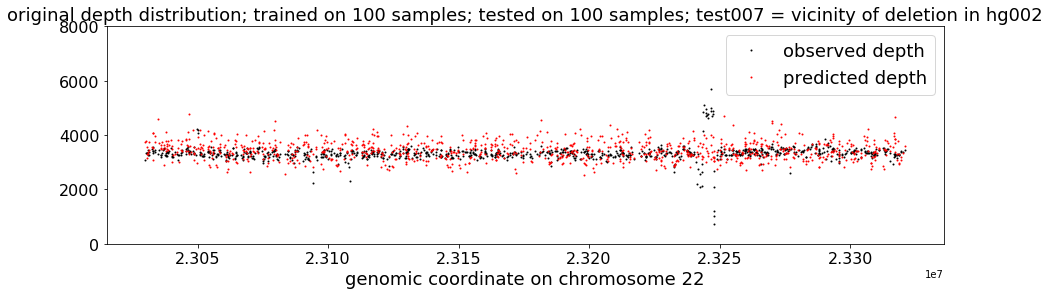

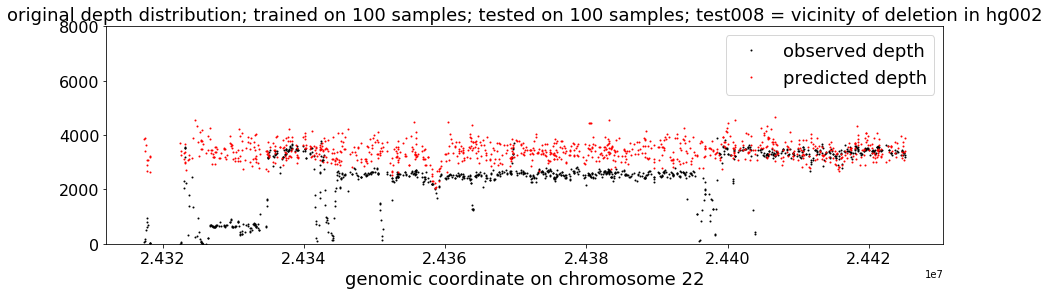

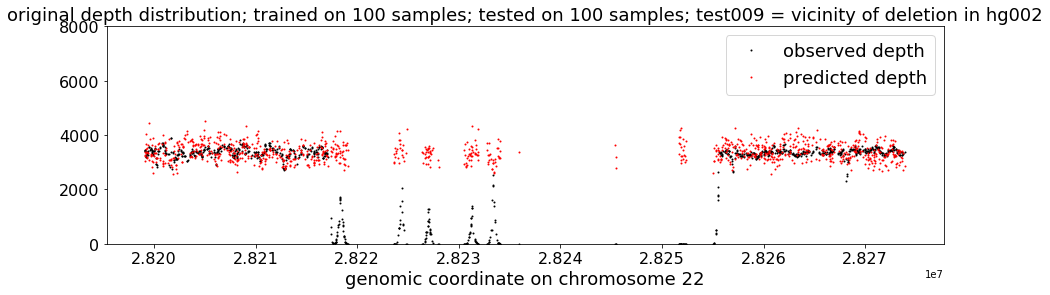

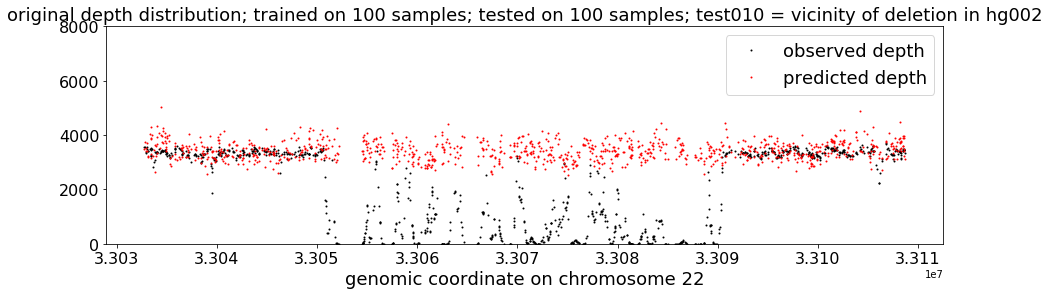

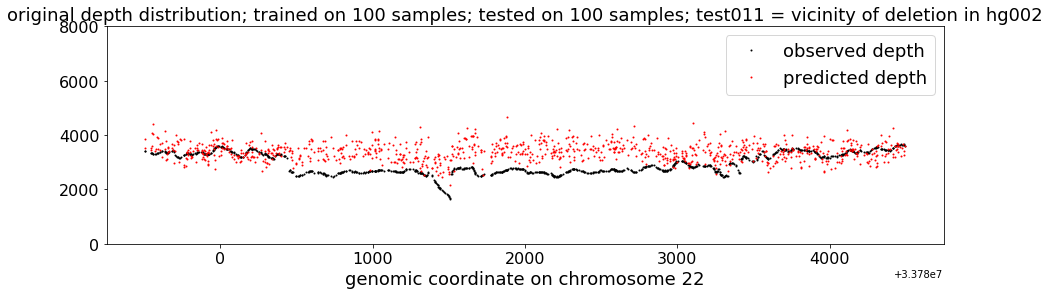

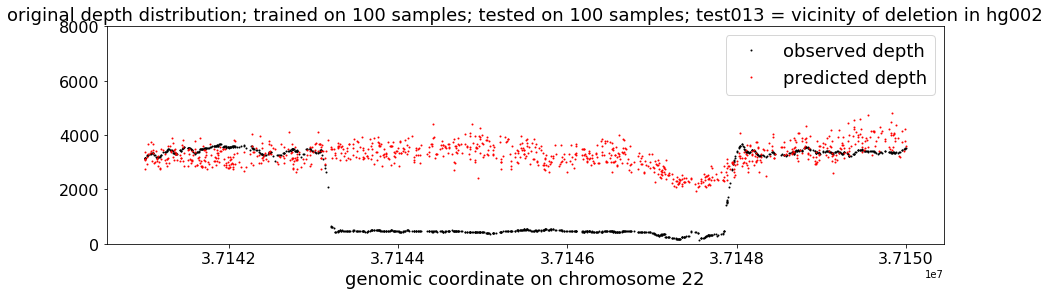

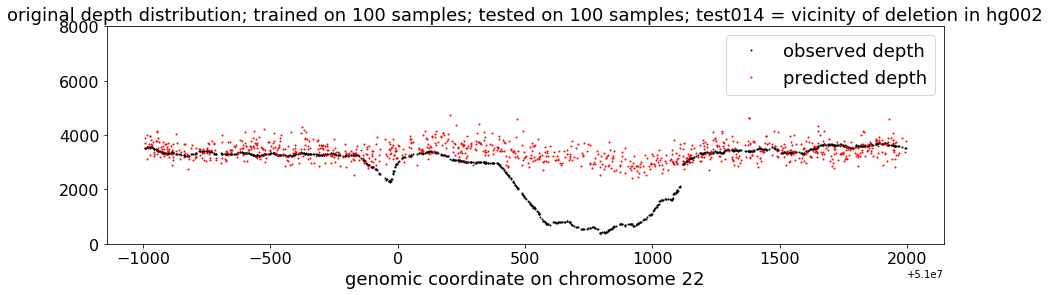

In [10]:
tests = [
    ['test004', 'duplication'], 
    ['test005', 'duplication'],
    ['test006', 'duplication'],
    ['test007', 'deletion'],
    ['test008', 'deletion'],
    ['test009', 'deletion'],
    ['test010', 'deletion'],
    ['test011', 'deletion'], 
    ['test013', 'deletion'], 
    ['test014', 'deletion']
]

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'original depth distribution; trained on 100 samples; tested on 100 samples; ' + test[0] + ' = vicinity of ' + test[1] + ' in hg002',
                  'test_file_name': 'test_100_samples/' + test[0] + '/test.pkl'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=8000)

Notice that `test006` `test008` `test011` `test013` exhibit what appear to be systematic biases. Could these biases in CEPH also be present in hg002 and could they be driving false-positive calls in hg002? If so, then, since the deep-learning model can predict those biases, it ought to be able to correct them and remove the false-positive calls. 

## Testing the multi-sample model on a single CEPH sample at hg002-CNVnator-call positions 

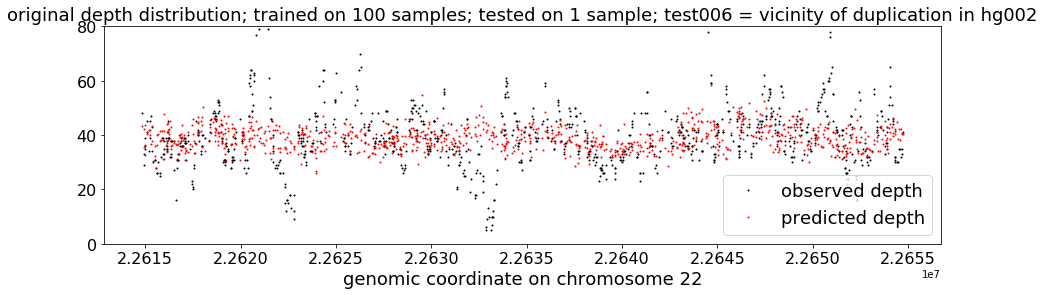

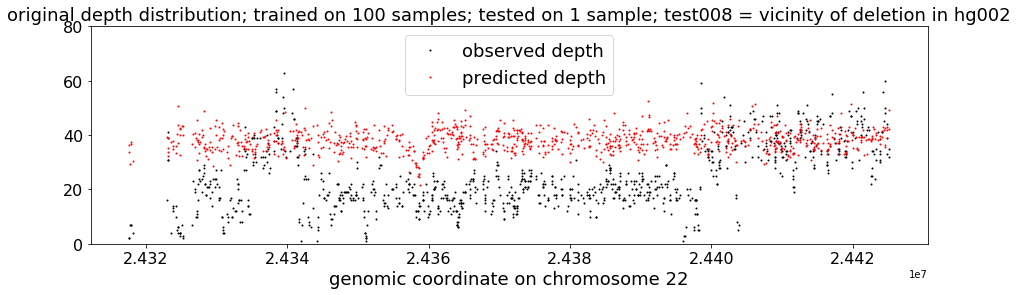

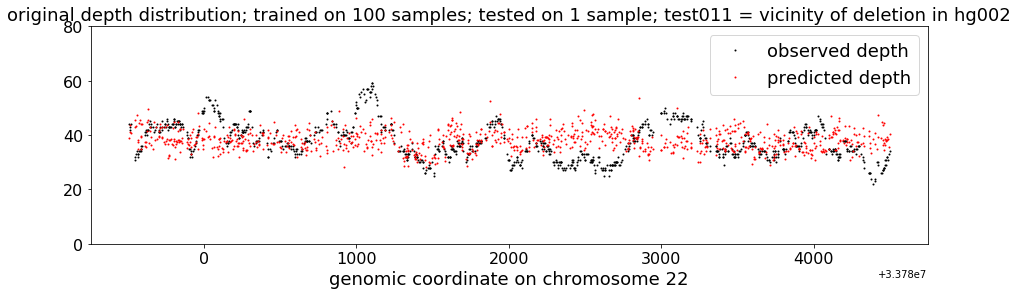

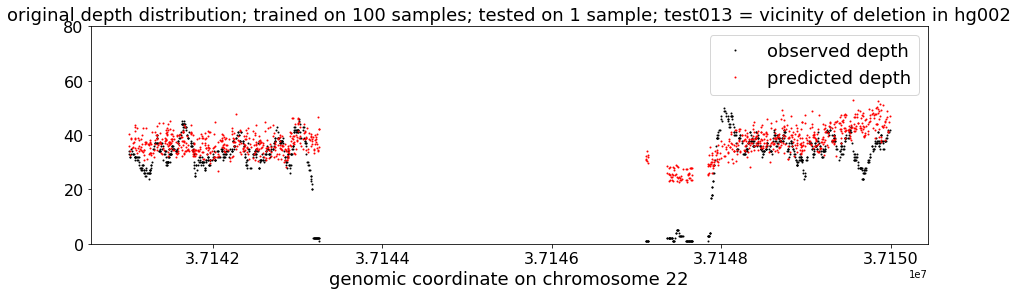

In [11]:
tests = [
    ['test006', 'duplication'],
    ['test008', 'deletion'],
    ['test011', 'deletion'], 
    ['test013', 'deletion'], 
]

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'original depth distribution; trained on 100 samples; tested on 1 sample; ' + test[0] + ' = vicinity of ' + test[1] + ' in hg002',
                  'test_file_name': 'test_1_sample/' + test[0] + '/test.pkl'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=80)

## Testing the multi-sample model on the hg002 sample at hg002-CNVnator-call positions 

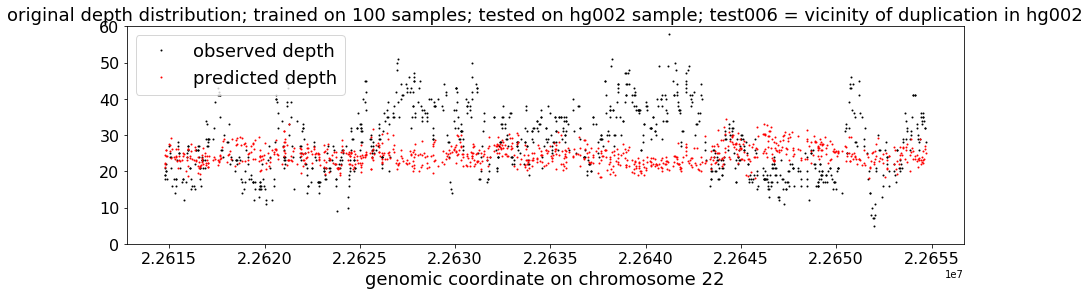

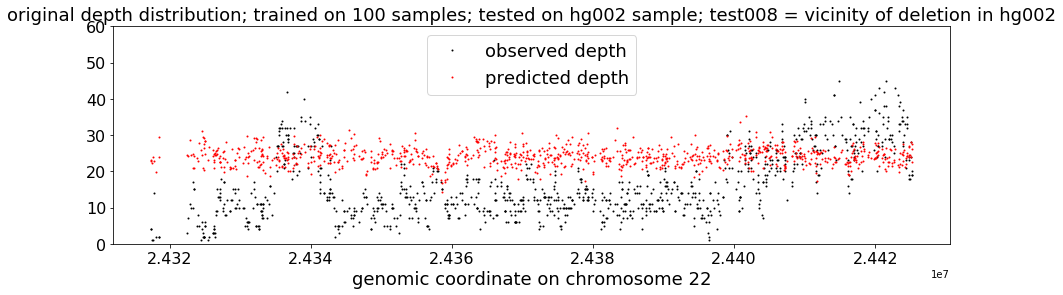

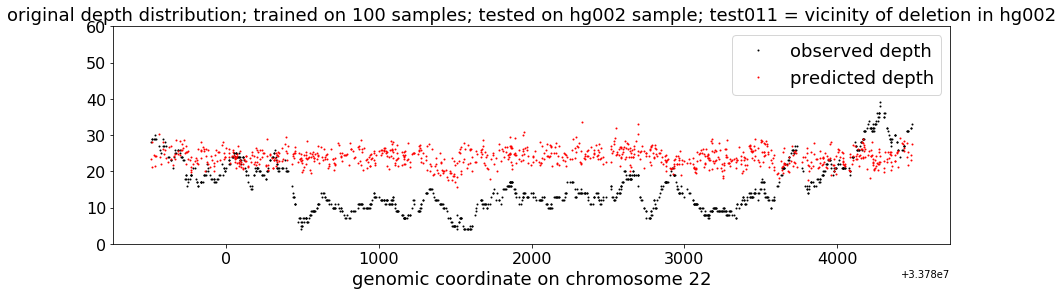

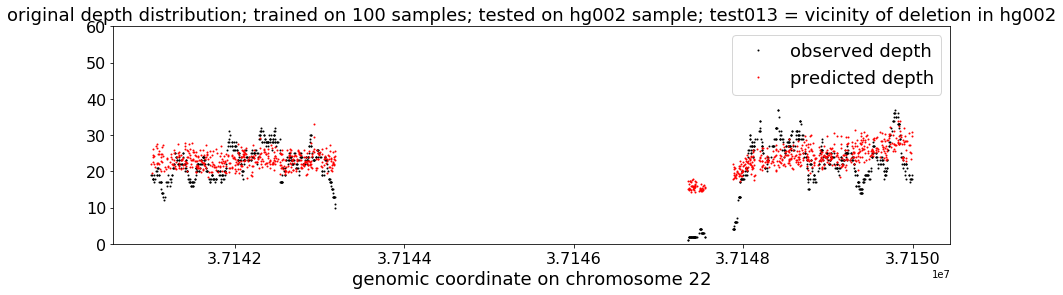

In [12]:
tests = [
    ['test006', 'duplication'],
    ['test008', 'deletion'],
    ['test011', 'deletion'], 
    ['test013', 'deletion'], 
]

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'original depth distribution; trained on 100 samples; tested on hg002 sample; ' + test[0] + ' = vicinity of ' + test[1] + ' in hg002',
                  'test_file_name': 'test_hg002/' + test[0] + '/test.pkl'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=60)

## Summary of Test006

To summarize, here are some data showing a systematic CEPH-specific bias in a region flagged by CNVnator as a CNV in hg002. The systematic bias is present in CEPH but not in hg002, presumably because hg002 sample was prepared in a different manner to the CEPH samples. 



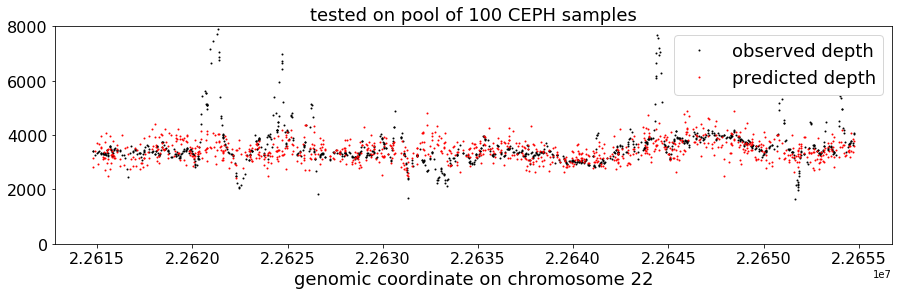

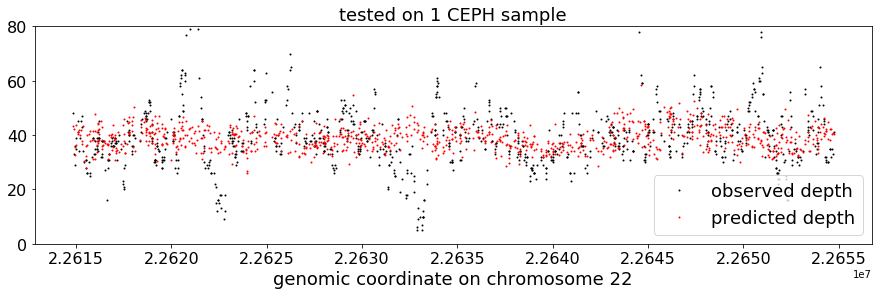

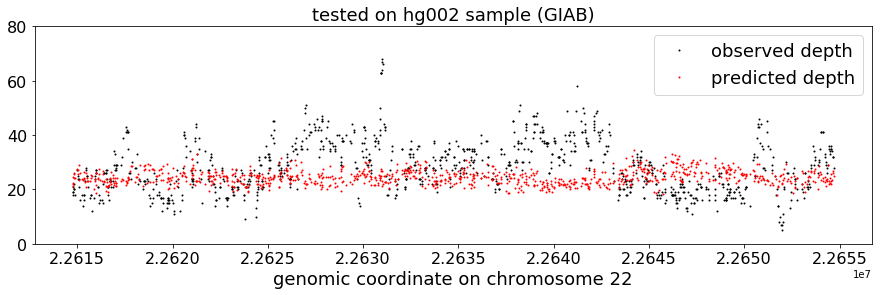

In [13]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on pool of 100 CEPH samples',
     'test_file_name': 'test_100_samples/test006/test.pkl',
     'max_depth': 8000},
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on 1 CEPH sample',
     'test_file_name': 'test_1_sample/test006/test.pkl',
    'max_depth': 80},
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on hg002 sample (GIAB)',
     'test_file_name': 'test_hg002/test006/test.pkl',
    'max_depth': 80}     
]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

## Testing the multi-sample model on the pool of CEPH samples at NAHR positions 

The deep-learning model was trained on the pooled CEPH samples, and therefore has no chance of correcting a false-positive call in hg002 that arose because of a systematic effect associated with the preparation of that sample. We therefore need candidate CNVs in a CEPH sample that were falsely called because of systematic effects associated with the CEPH preparation procedure. 

One approach is to pull out regions that are susceptible to NAHR. [Here](http://home.chpc.utah.edu/~u1072557/swarm/low_depth/) are the locations of NAHR regions on chromosome 22, prepared by Jon Belyeu. Let's look at coverage profiles in these regions ...

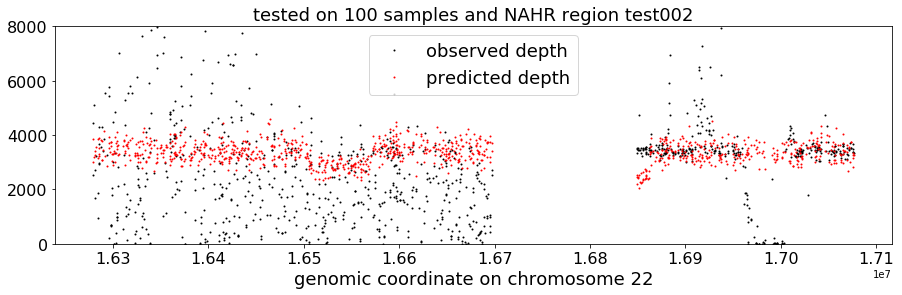

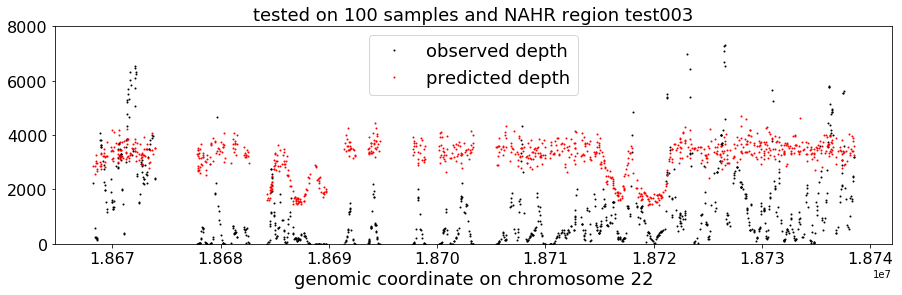

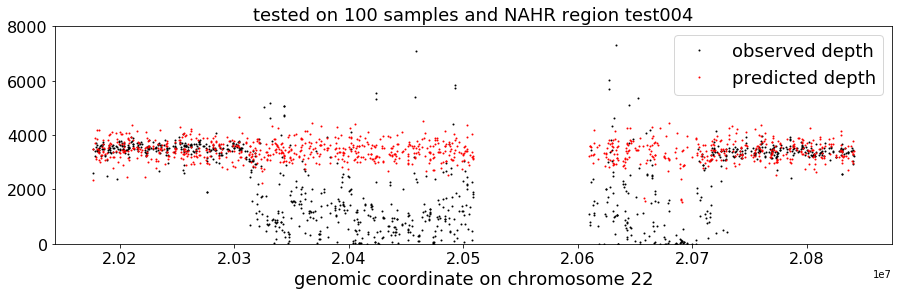

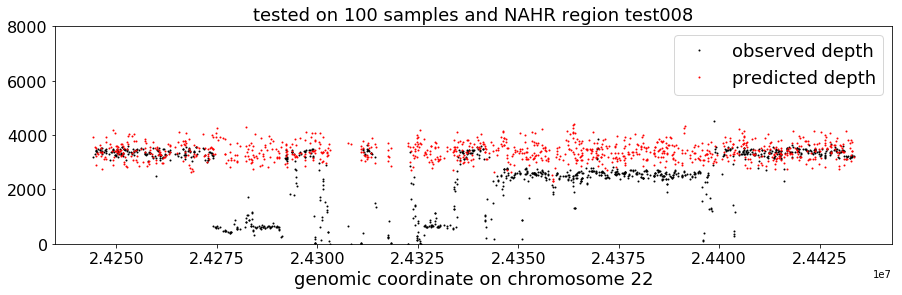

In [14]:
tests = [
    'test002',
    'test003',
    'test004',
    'test008',
]

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'tested on 100 samples and NAHR region ' + test,
                  'test_file_name': 'test_100_samples_NAHR/' + test + '/test.pkl'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=8000)

It turns out that there are only four non-overlapping NAHR regions on chromosome 22. None of these are good candidates for systematic sequence-dependent biases that the deep-learning model could conceivably capture. This is because they lie in a generally "noisy" part of the chromosome, as you can see by the erratic behavior of the coverage profiles. Presumably this is because repetitive regions confound alignments and therefore make depth profiles "noisy".

## Testing the multi-sample model on a single CEPH sample at NAHR positions 

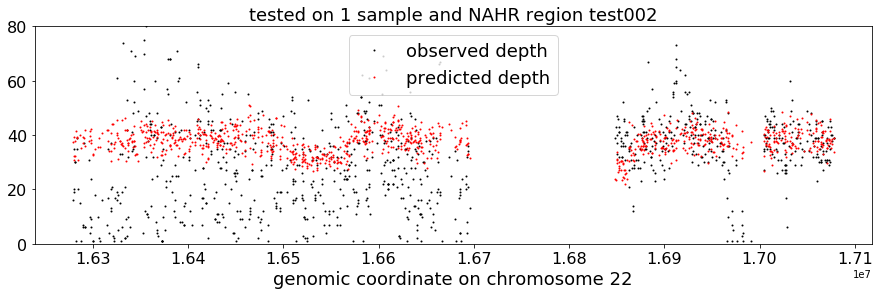

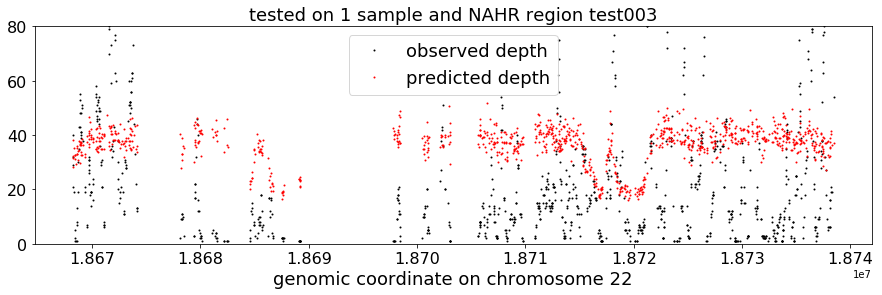

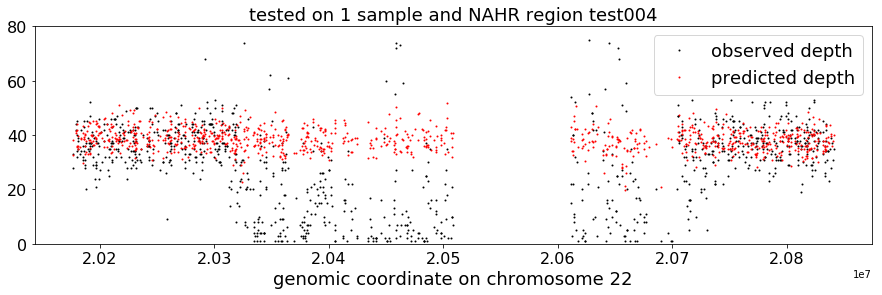

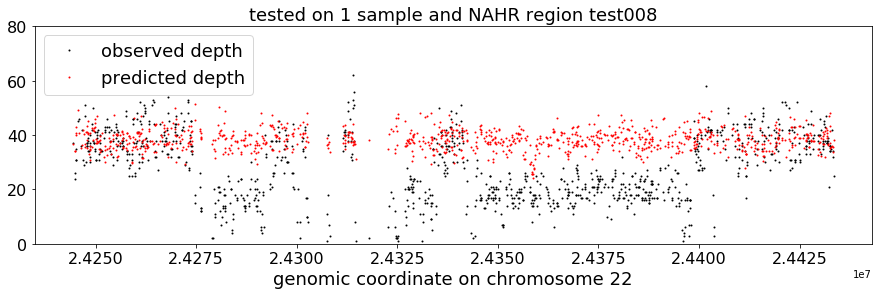

In [15]:
trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'tested on 1 sample and NAHR region ' + test,
                  'test_file_name': 'test_1_sample_NAHR/' + test + '/test.pkl'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=80)

## Testing the multi-sample model on the pool of CEPH samples at positions called by CNVnator in one of the CEPH samples

Next, I ran CNVnator on one of the CEPH samples (#8412) and examined the calls it made in "better-behaved" parts of the genome (greater than 24Mb) ...

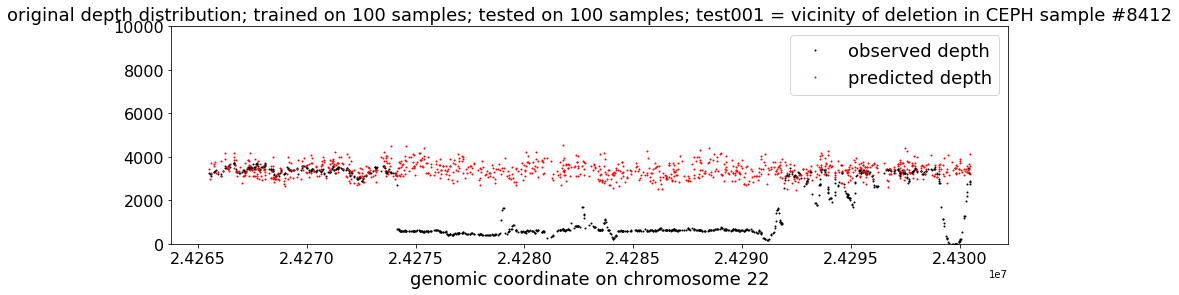

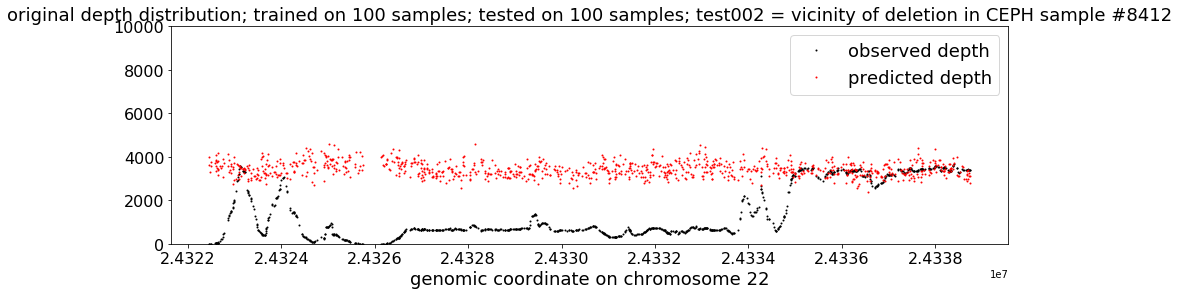

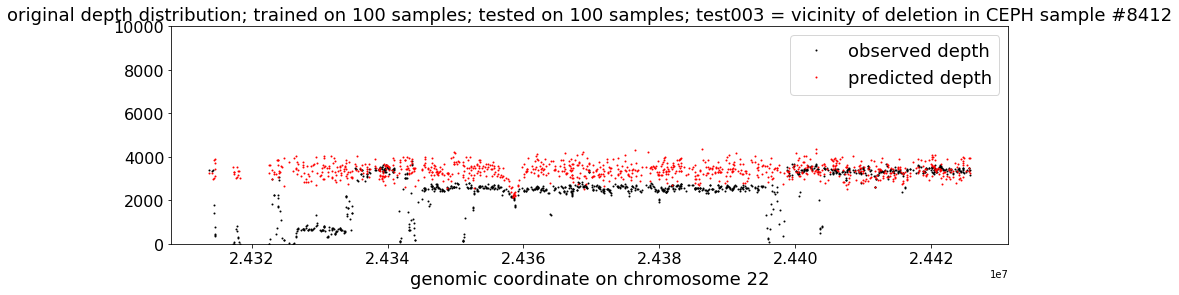

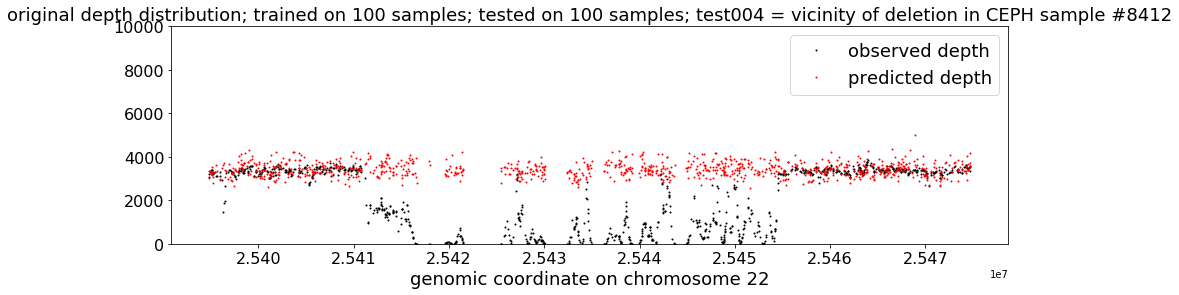

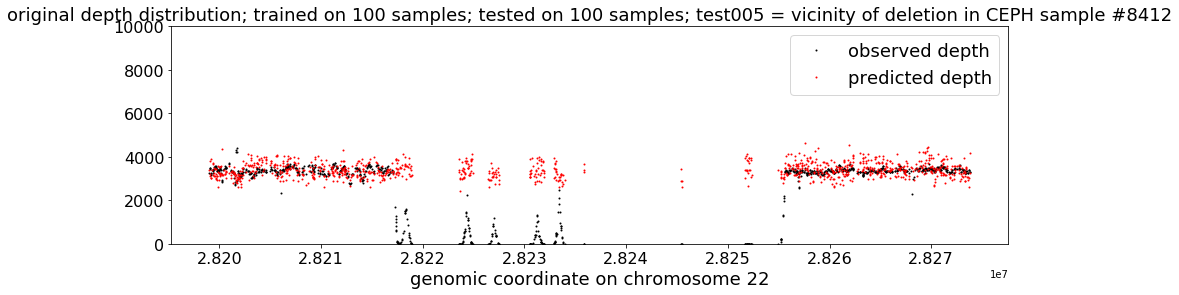

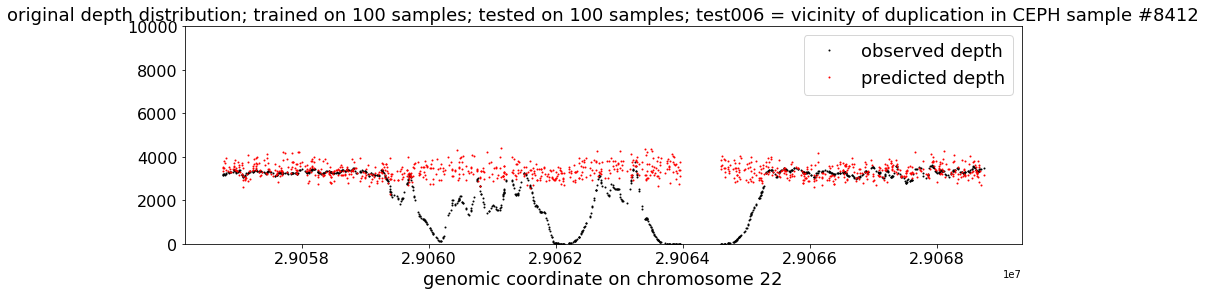

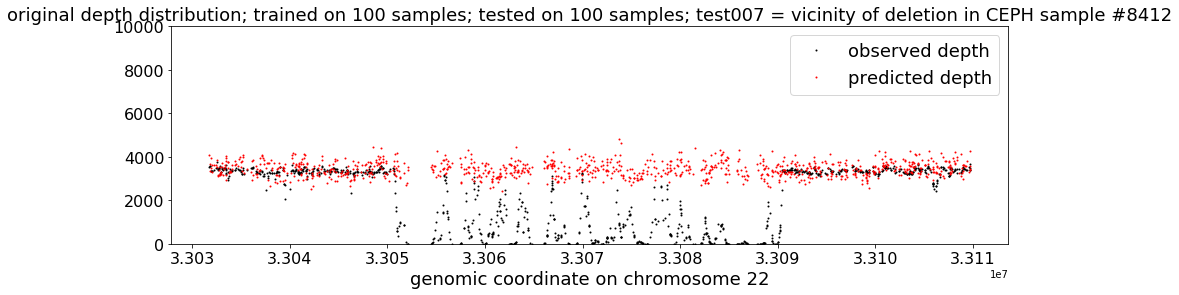

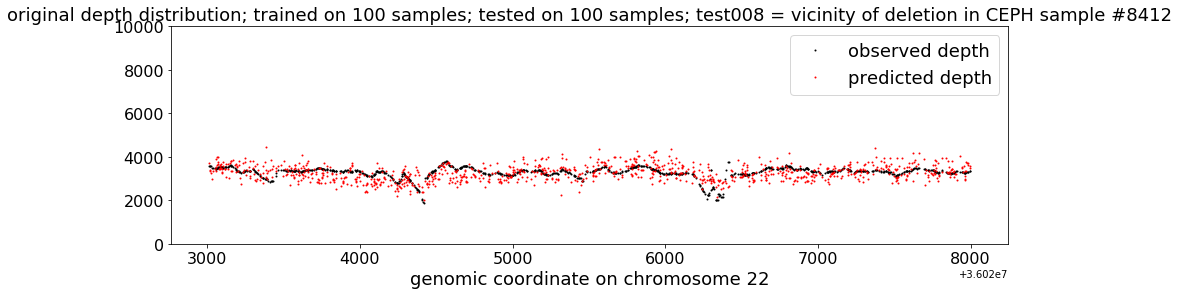

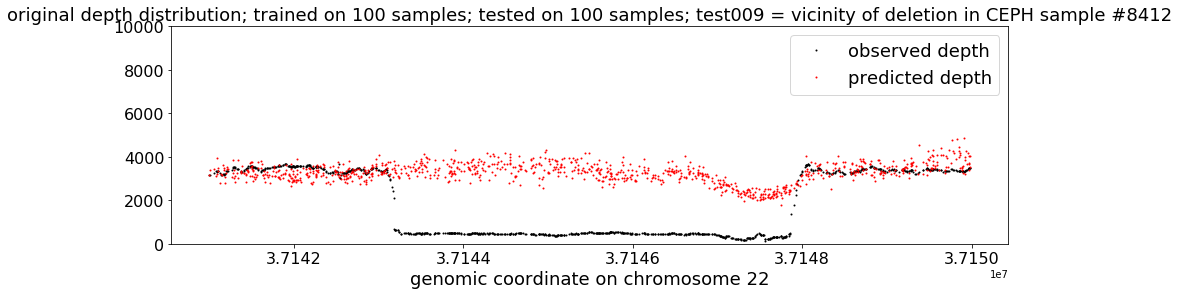

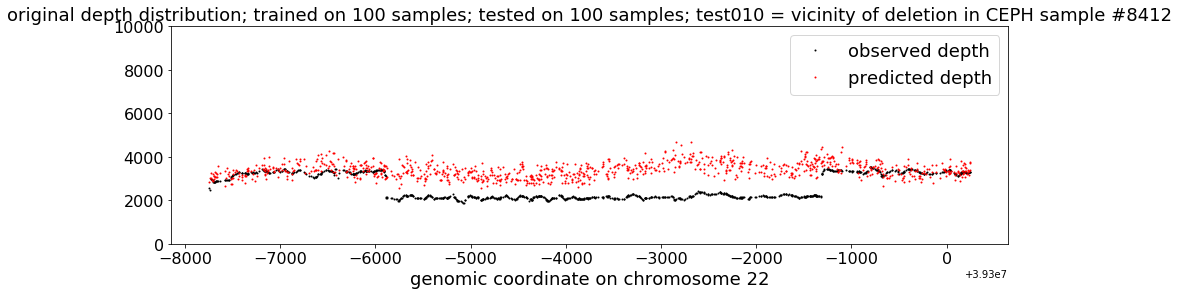

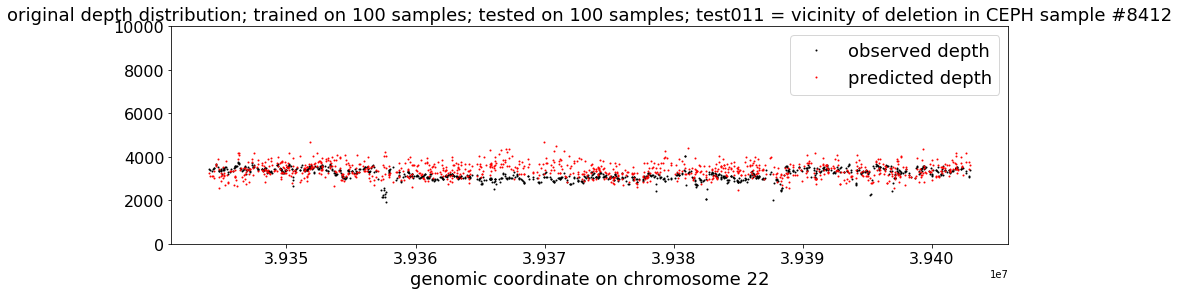

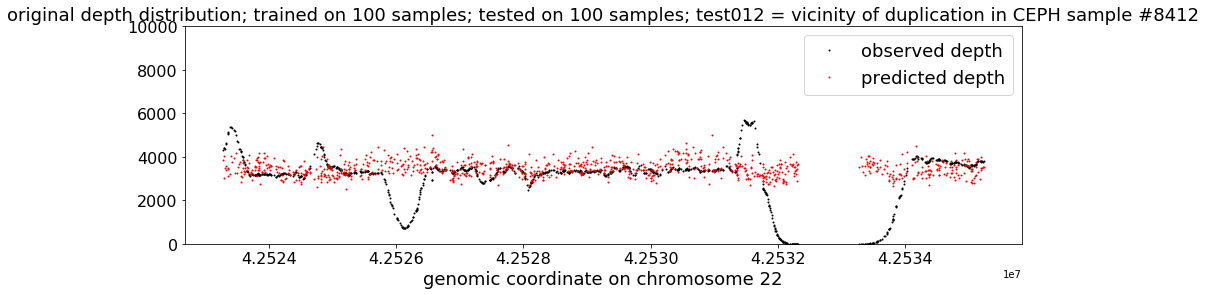

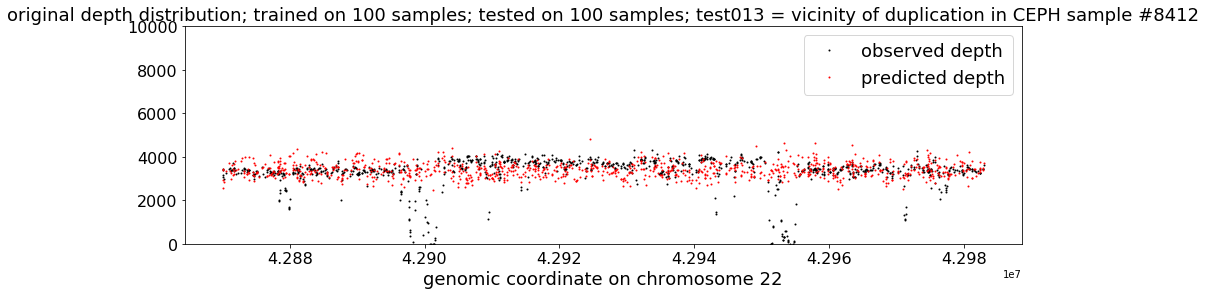

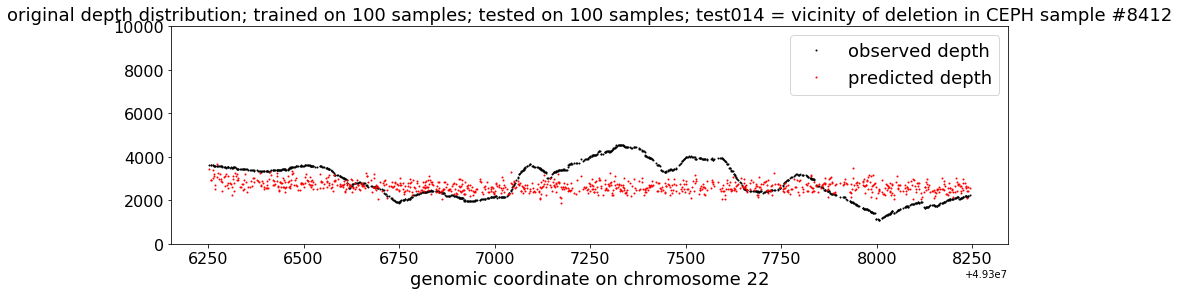

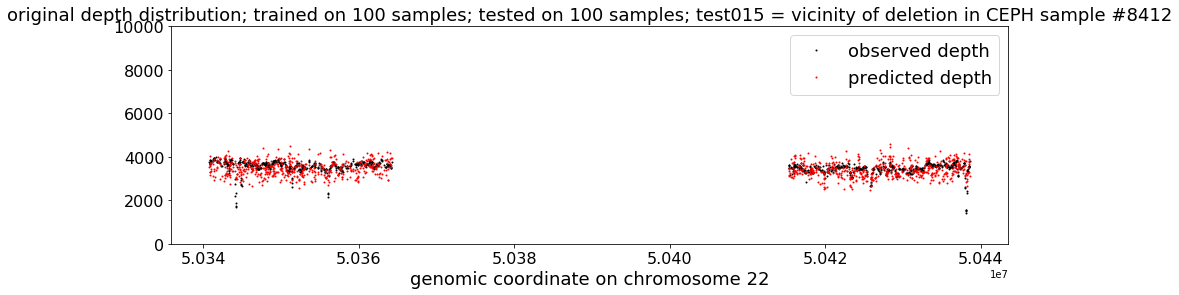

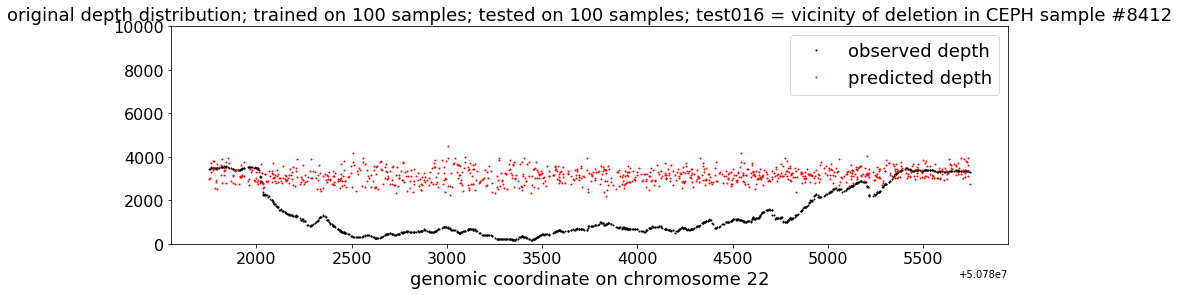

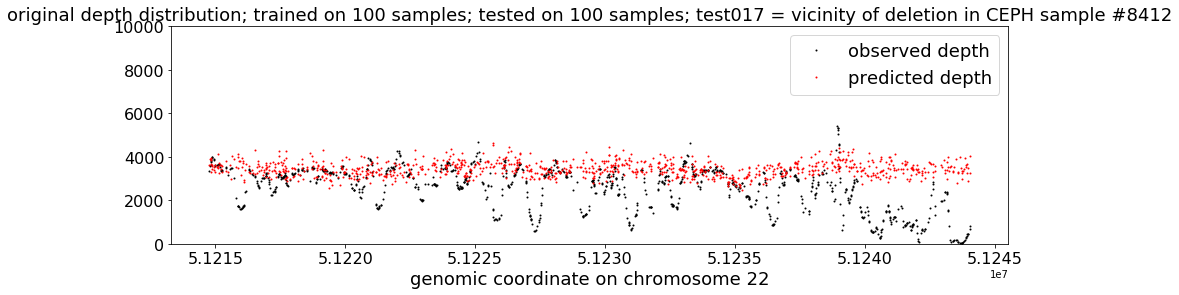

In [16]:
tests = [
    ['test001', 'deletion'],
    ['test002', 'deletion'],
    ['test003', 'deletion'],
    ['test004', 'deletion'],
    ['test005', 'deletion'],
    ['test006', 'duplication'],
    ['test007', 'deletion'],
    ['test008', 'deletion'],
    ['test009', 'deletion'],
    ['test010', 'deletion'],
    ['test011', 'deletion'],
    ['test012', 'duplication'],
    ['test013', 'duplication'],
    ['test014', 'deletion'],
    ['test015', 'deletion'],
    ['test016', 'deletion'],
    ['test017', 'deletion']
]

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'original depth distribution; trained on 100 samples; tested on 100 samples; ' + test[0] + ' = vicinity of ' + test[1] + ' in CEPH sample #8412',
                  'test_file_name': 'test__100samples__8412_CNVnator_calls/' + test[0] + '/test.pkl', 
                  'depth_file_name': '../data/depths/100.multicov.int32.bin'} for test in tests]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=10000, logy_scale=False)

## Original depth distribution during training; trained on 100 samples; tested on CEPH sample #8412; Test 003

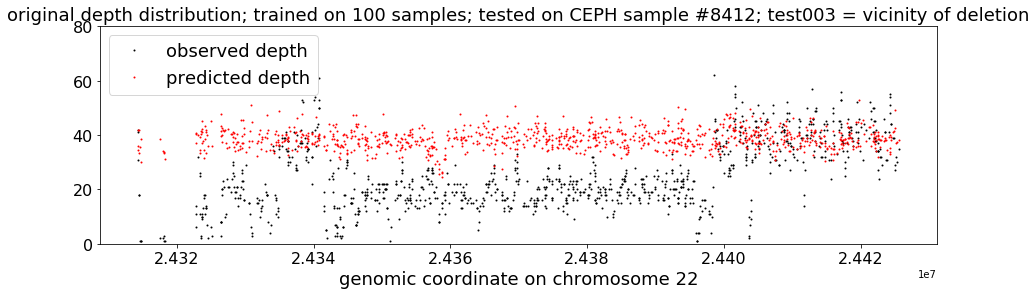

In [17]:
test = ['test003', 'deletion']

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'original depth distribution; trained on 100 samples; tested on CEPH sample #8412; ' + test[0] + ' = vicinity of ' + test[1],
                  'test_file_name': 'test__1sample__8412_CNVnator_calls/' + test[0] + '/test.pkl', 
                  'depth_file_name': '../../data/depths/1.multicov.int32.bin'}]

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=80, logy_scale=False)

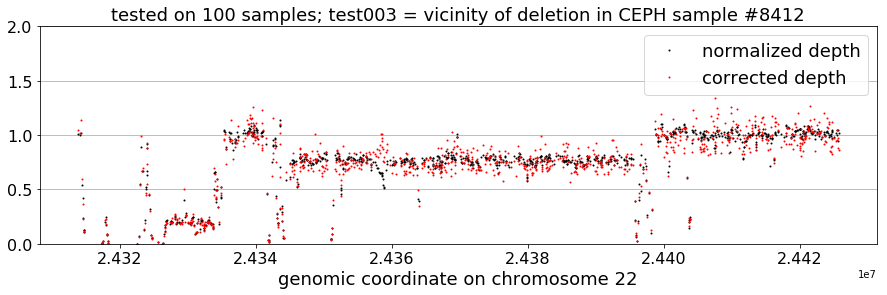

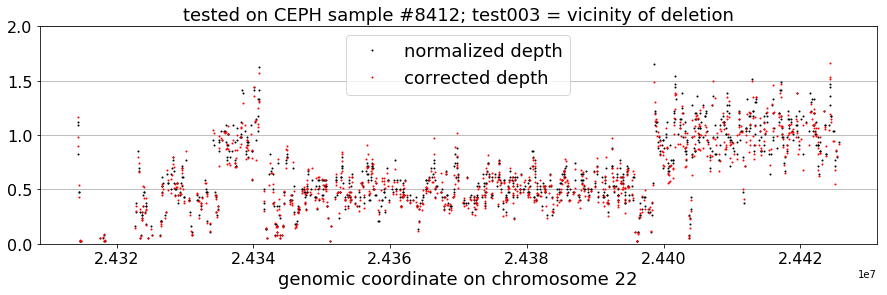

In [18]:
test = ['test003', 'deletion']

trained_models = [{'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'tested on 100 samples; ' + test[0] + ' = vicinity of ' + test[1] + ' in CEPH sample #8412',
                  'test_file_name': 'test__100samples__8412_CNVnator_calls/' + test[0] + '/test.pkl', 
                  'depth_file_name': '../data/depths/100.multicov.int32.bin'},
                 {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
                  'annotation': 'tested on CEPH sample #8412; ' + test[0] + ' = vicinity of ' + test[1],
                  'test_file_name': 'test__1sample__8412_CNVnator_calls/' + test[0] + '/test.pkl', 
                  'depth_file_name': '../data/depths/1.multicov.int32.bin'}]

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

## Trained upon 100 CEPH samples; Tested on CEPH samples at locus "test008", which is a cnvnator-call from hg002

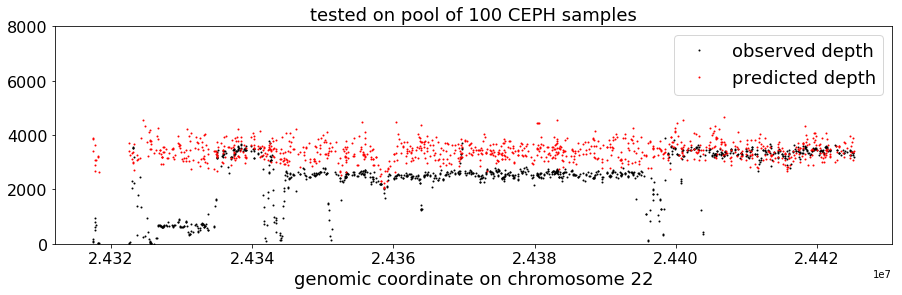

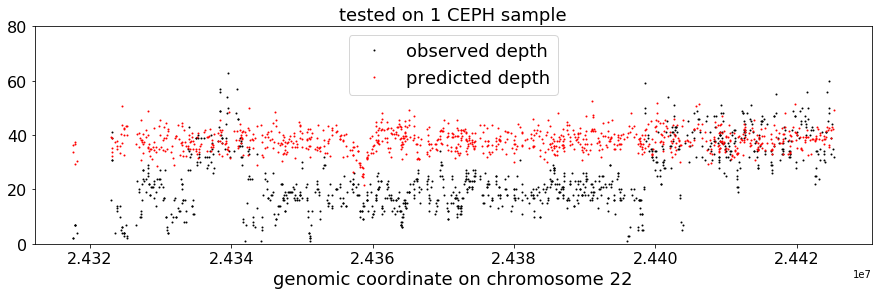

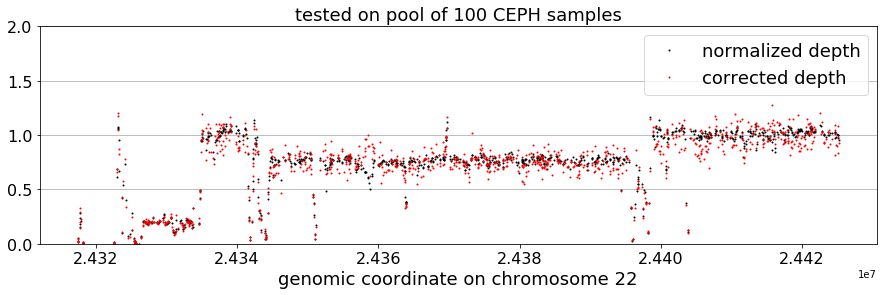

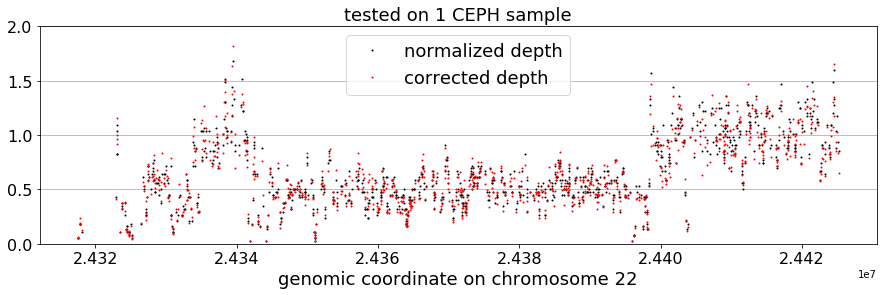

In [19]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on pool of 100 CEPH samples',
     'test_file_name': 'test_100_samples/test008/test.pkl',
     'max_depth': 8000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on 1 CEPH sample',
     'test_file_name': 'test_1_sample/test008/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

## Trained upon 100 CEPH samples; Tested on CEPH samples at locus "test001", which is a cnvnator-call made from CEPH sample #8412

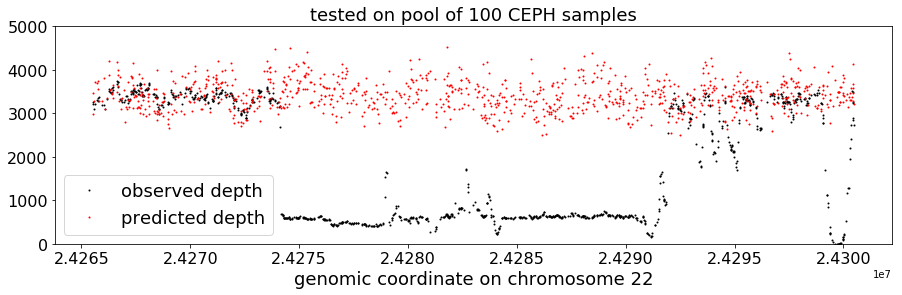

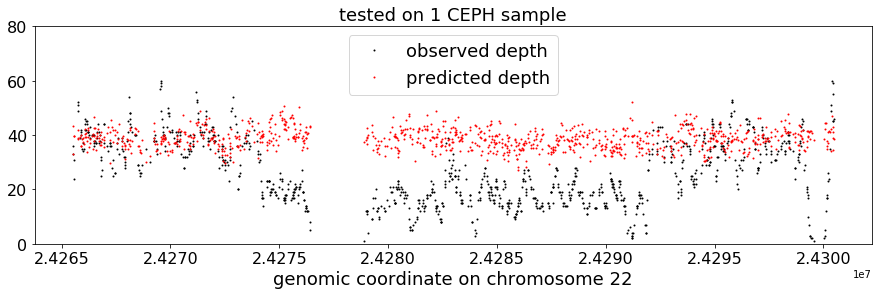

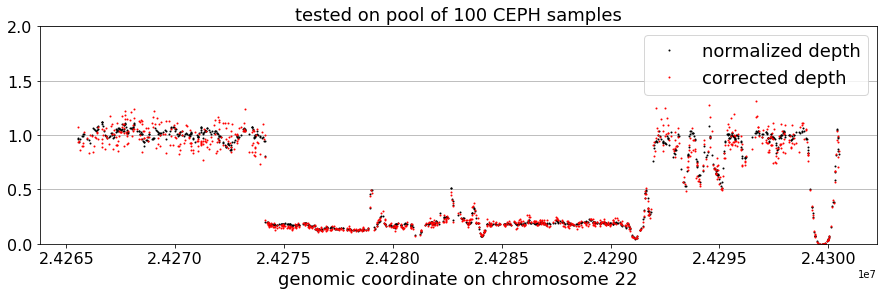

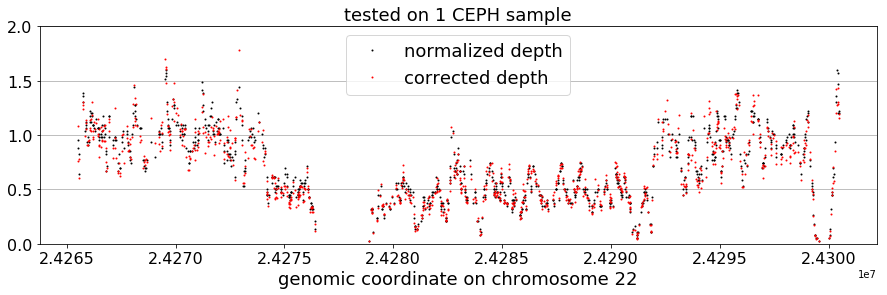

In [20]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on pool of 100 CEPH samples',
     'test_file_name': 'test__100samples__8412_CNVnator_calls/test001/test.pkl',
     'max_depth': 5000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on 1 CEPH sample',
     'test_file_name': 'test__1sample__8412_CNVnator_calls/test001/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin', 
     'figure_file_name': '1.3B.pdf'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

## Trained upon 100 CEPH samples; Tested on CEPH samples at locus "test009", which is a cnvnator-call made from CEPH sample #8412

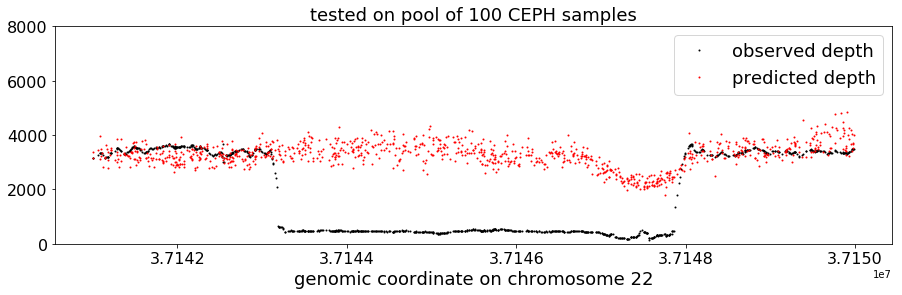

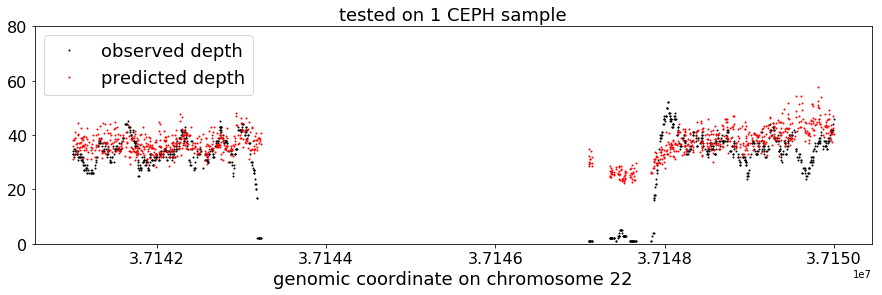

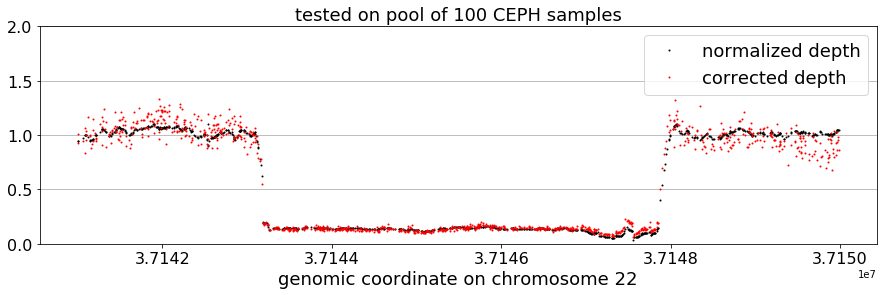

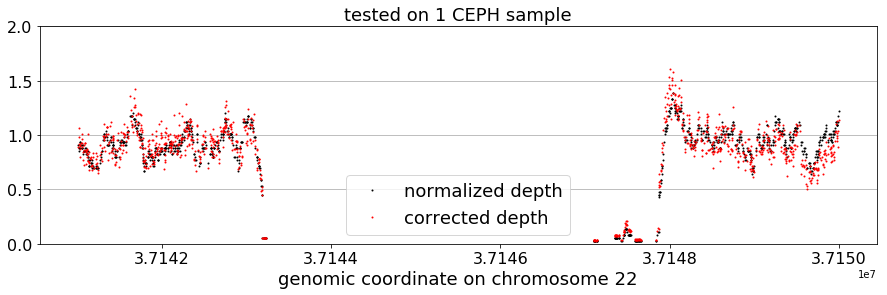

In [21]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on pool of 100 CEPH samples',
     'test_file_name': 'test__100samples__8412_CNVnator_calls/test009/test.pkl',
     'max_depth': 8000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 
     'annotation': 'tested on 1 CEPH sample',
     'test_file_name': 'test__1sample__8412_CNVnator_calls/test009/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

## Original distribution of read depths in training set; Training on 100 CEPH samples for longer than 2 days

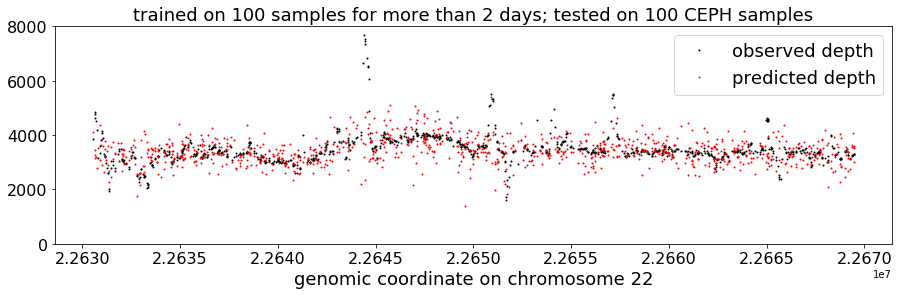

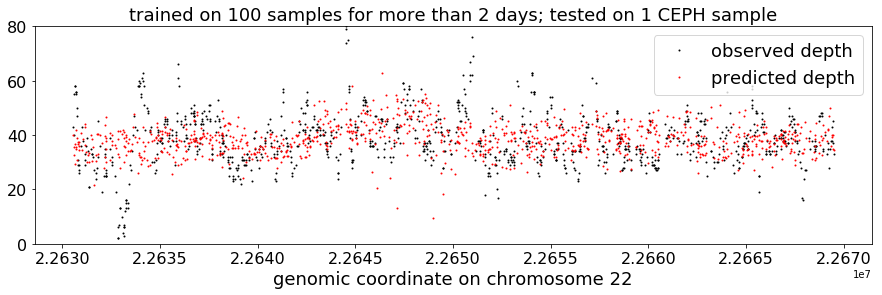

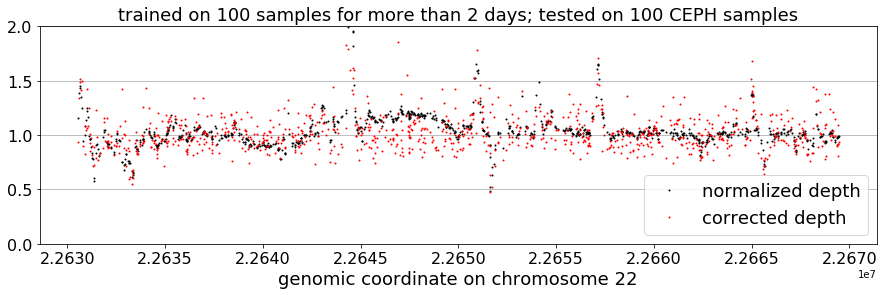

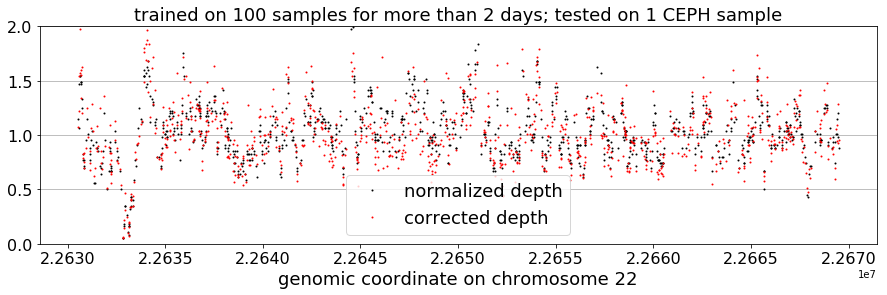

In [22]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_originalDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 100 CEPH samples',
     'test_file_name': 'test_100samples/test001/test.pkl',
     'max_depth': 8000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_final/09_100samples_originalDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 1 CEPH sample',
     'test_file_name': 'test_1sample/test001/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

observed_depth_mean 3284.842
feature_independent_cost 65.99666561647801


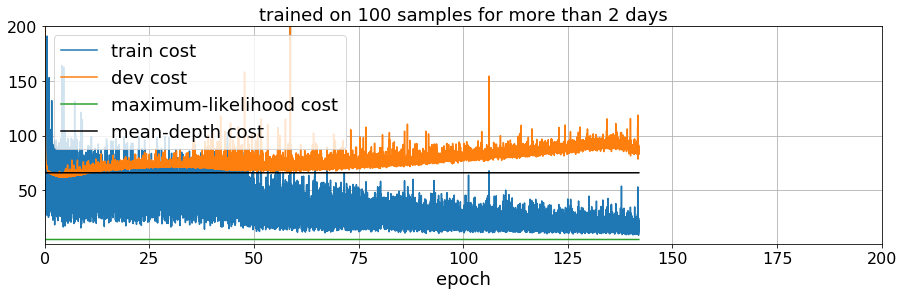

In [22]:
start_epoch = 0.01
end_epoch = 200
min_cost = 1

%matplotlib inline 

trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_originalDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days'}
]

from plot import plot_costs_all
plot_costs_all(trained_models, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=200)

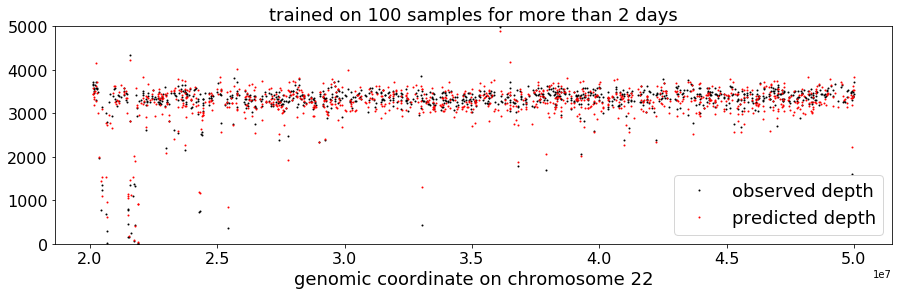

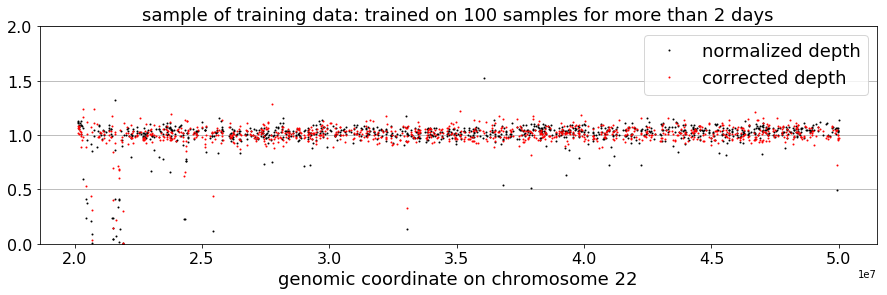

In [23]:
from plot import plot_depths_train_all
plot_depths_train_all(trained_models, chromosome_number=22, max_depth=5000)
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models, chromosome_number=22)

## Uniform distribution of depths in training set: Training on 100 CEPH samples for longer than 2 days  

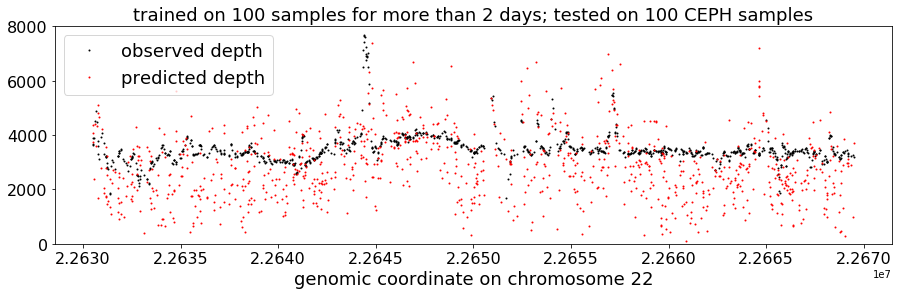

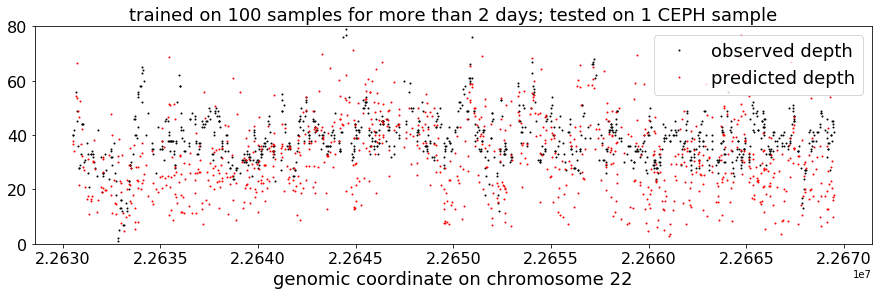

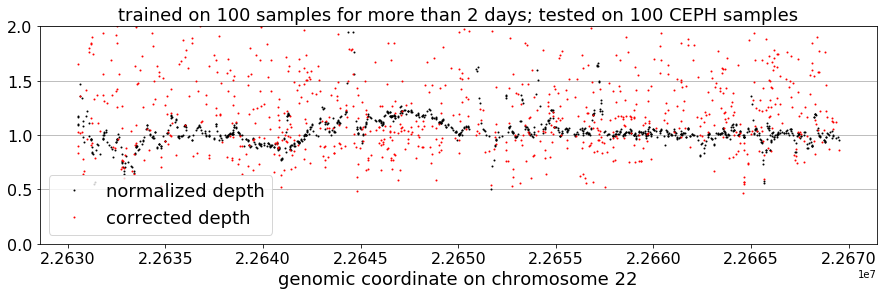

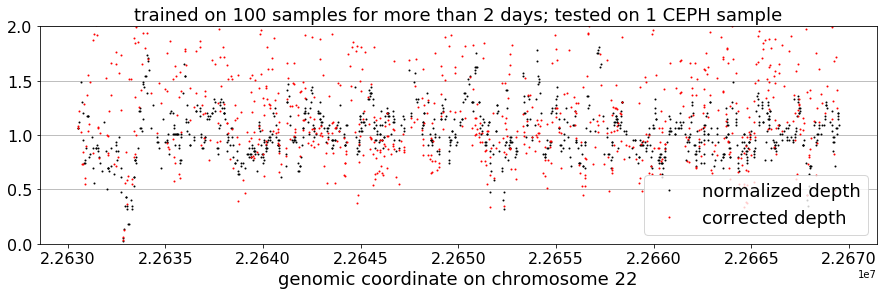

In [1]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_uniformDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 100 CEPH samples',
     'test_file_name': 'test_100samples/test001/test.pkl',
     'max_depth': 8000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_final/09_100samples_uniformDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 1 CEPH sample',
     'test_file_name': 'test_1sample/test001/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

observed_depth_mean 2975.668
feature_independent_cost 589.9460325591522


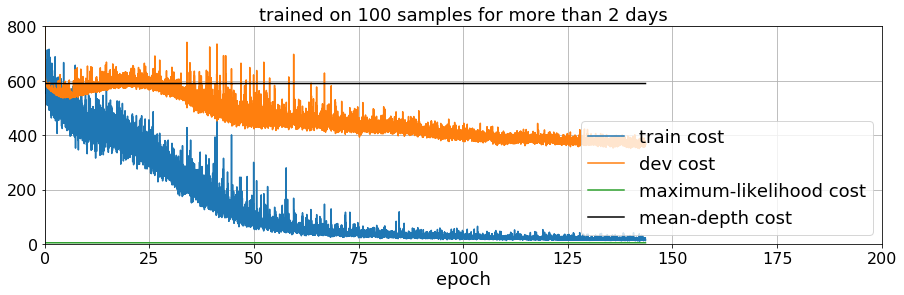

In [2]:
start_epoch = 0.01
end_epoch = 200
min_cost = 1

%matplotlib inline 

trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_uniformDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days'}
]

from plot import plot_costs_all
plot_costs_all(trained_models, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=800)

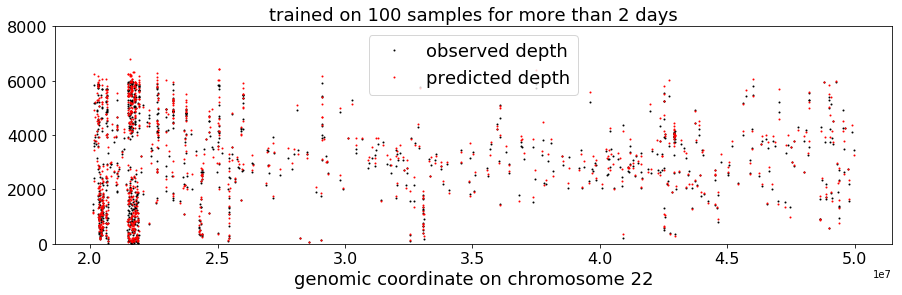

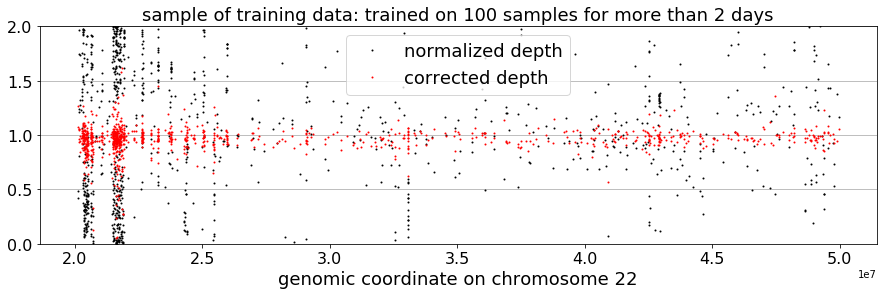

In [26]:
from plot import plot_depths_train_all
plot_depths_train_all(trained_models, chromosome_number=22, max_depth=8000)
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models, chromosome_number=22)

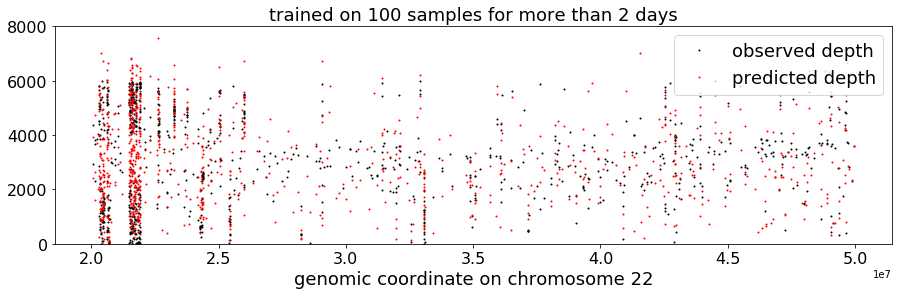

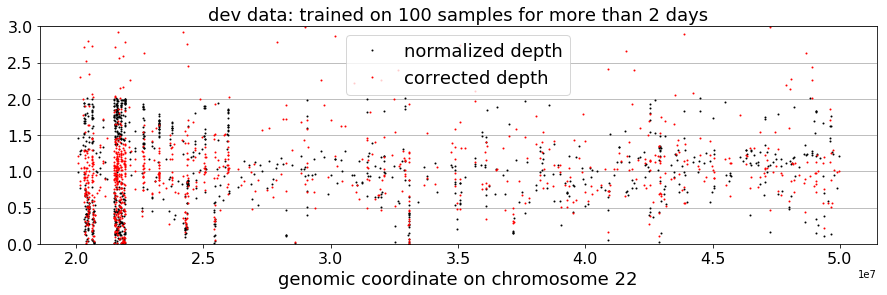

In [33]:
from plot import plot_depths_dev_all
plot_depths_dev_all(trained_models, chromosome_number=22, max_depth=8000)
from plot import plot_corrected_depths_dev_all
plot_corrected_depths_dev_all(trained_models, chromosome_number=22)

## Humped distribution of depths in training set: Training on 100 CEPH samples for longer than 2 days  

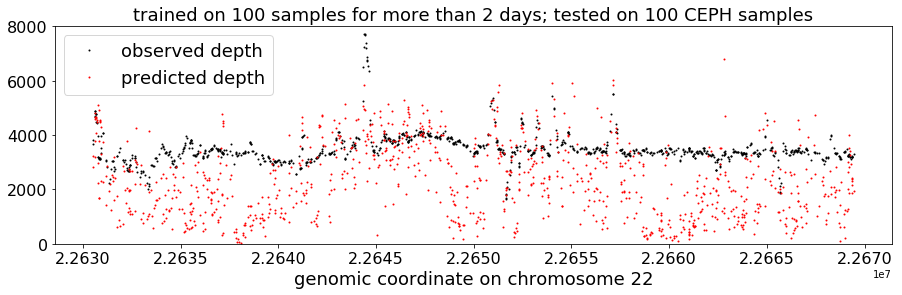

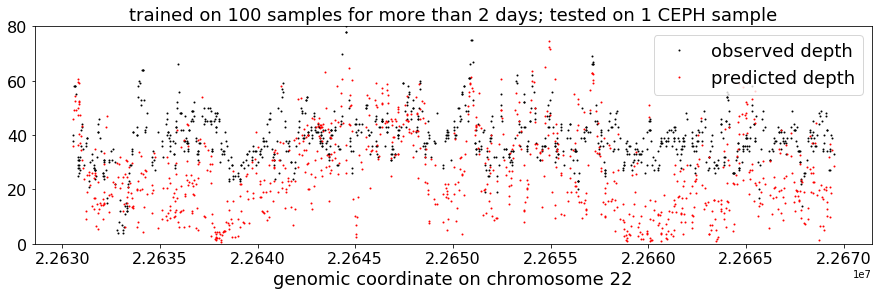

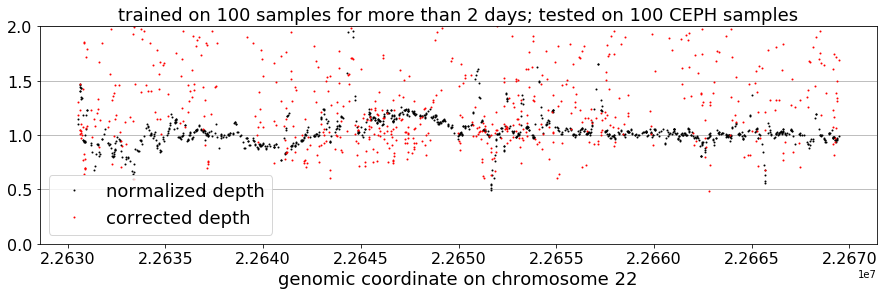

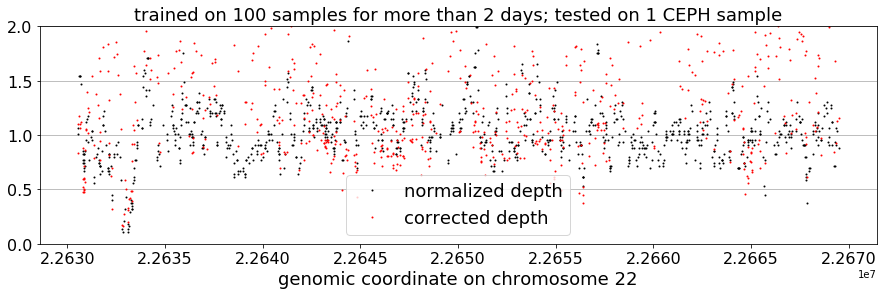

In [31]:
trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_humpedDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 100 CEPH samples',
     'test_file_name': 'test_100samples/test001/test.pkl',
     'max_depth': 8000,
     'depth_file_name': '../data/depths/100.multicov.int32.bin'},
    {'path': '../data/trained_models/09_100samples_final/09_100samples_humpedDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days; tested on 1 CEPH sample',
     'test_file_name': 'test_1sample/test001/test.pkl',
     'max_depth': 80,
     'depth_file_name': '../data/depths/1.multicov.int32.bin'}
]

%matplotlib inline

from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22)

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22)

observed_depth_mean 2807.989
feature_independent_cost 763.4439413174799


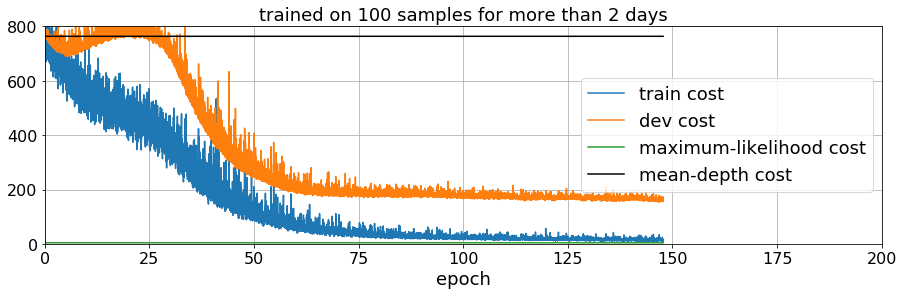

In [28]:
start_epoch = 0.01
end_epoch = 200
min_cost = 1

%matplotlib inline 

trained_models = [
    {'path': '../data/trained_models/09_100samples_final/09_100samples_humpedDistribution/', 
     'annotation': 'trained on 100 samples for more than 2 days'}
]

from plot import plot_costs_all
plot_costs_all(trained_models, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=800)

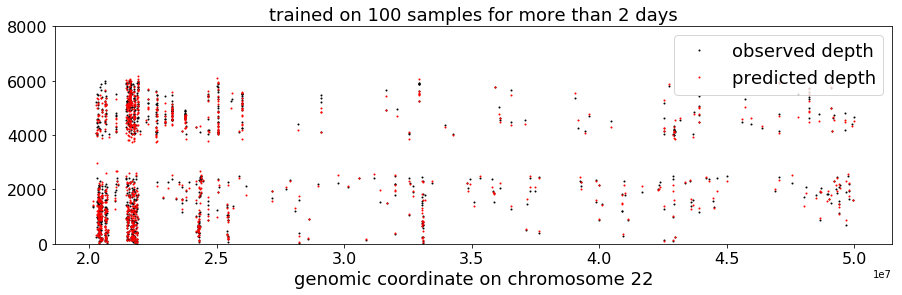

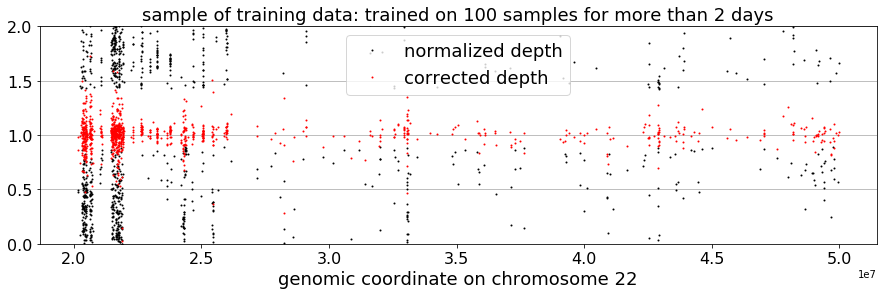

In [29]:
from plot import plot_depths_train_all
plot_depths_train_all(trained_models, chromosome_number=22, max_depth=8000)
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models, chromosome_number=22)